In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import pickle as pkl
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
import keras
import keras_metrics as km

from keras.callbacks import TensorBoard
from keras import regularizers
from custom_callbacks import LrFinder
from custom_callbacks import CycleLearner
from custom_callbacks import reset_weights
from keras.callbacks import ModelCheckpoint
from time import time
from keras.layers import Input, Dense,Dropout,BatchNormalization,LSTM,GRU,Bidirectional,Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D,merge
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras import backend as K
import math
import json


Using TensorFlow backend.


In [2]:
train_filepath = "train_workspace/"
animalList = ["Human","Pig","Chicken","Rat","Mouse","Dog"]
levelList = ["Strict","Relaxed","Intermediate"]
mutation_levels = ["VeryLow","Low","Medium","High"]
sb.set_style("darkgrid")

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3944960610876507070
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 122486784
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7265349798827387023
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [4]:
working_level = "Strict"

In [5]:
def get_df_dict(level):
    df_dict = {}    
    current_file_path = train_filepath + level + "/mutated/"
    for mutation_level in mutation_levels:                
        df_dict[mutation_level] = pd.read_pickle(current_file_path +"ohnologs-complete-" + mutation_level + "2.pkl")        
    return df_dict

In [6]:
def get_df_dict_paralogs(level):
    df_dict = {}    
    current_file_path = train_filepath + level + "/mutated/"
    for mutation_level in mutation_levels:                
        df_dict[mutation_level] = pd.read_pickle(current_file_path +"no-ohnologs-complete-" + mutation_level + "2.pkl")        
    return df_dict

In [7]:
def get_df_dict_no_ohnologs(level):
    df_dict = {}    
    current_file_path = train_filepath + level + "/mutated/"
    for mutation_level in mutation_levels:                
        df_dict[mutation_level] = pd.read_pickle(current_file_path +"paralogs-complete-" + mutation_level + "2.pkl")        
    return df_dict

In [8]:
df_dict_ohnologs = get_df_dict(working_level)

In [9]:
df_dict_paralogs = get_df_dict_paralogs(working_level)

In [10]:
df_dict_no_ohnologs = get_df_dict_no_ohnologs(working_level)

In [11]:
df_dict = df_dict_ohnologs

In [12]:
df_dict_paralogs["Low"].head()

,Is_Ohnolog,Is_Paralog,Sequence-1,Sequence-1 GC,Sequence-1 Id,Sequence-1 Length,Sequence-1-Transcript Id,Sequence-2,Sequence-2 GC,Sequence-2 Id,...,Nr Gap Open_Low_M,Evalue_Low_M,Bit Score_Low_M,Percent Identical Matches_Total_M,Aligment Length_Total_M,Nr Mismatch_Total_M,Nr Gap Open_Total_M,Evalue_Total_M,Bit Score_Total_M,Nr Hits_M
0,0,0.0,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCCACTTCCTCCT...,0.397366,ENSSSCG00000030602,911,ENSSSCT00000030820,GAGTGCAAAAATGCAGAGCAATAAAACTTTTAACTTGGAGAAGCAA...,0.485071,ENSSSCG00000023245,...,0.000000,0.730000,21.400000,100.000000,11.000000,0.000000,0.000000,0.730000,21.400000,2
1,0,0.0,AGCCTTGCAATCCATGCCGAGAGGAAGGCAGTGCGAGCCCGCGCCA...,0.409615,ENSG00000186479,4160,ENST00000334025,GTCCGTGGTAGGAATGCATCTTAGTTGAATATCCTCTTCAGGTTAA...,0.464370,ENSG00000157212,...,0.047619,5.933333,22.033333,98.364476,12.095238,0.190476,0.047619,5.933333,22.033333,21
2,0,0.0,AGGCGCGCTGCGGGGGAGGGGAGCGCTGATGCAAGAGGCGAGCGCG...,0.433076,ENSGALG00000033196,1427,ENSGALT00000067846,CAGCTGCAGCATGAGCAGCCCGGTGTCCGGGTCGGGCACGCAGCGG...,0.696822,ENSGALG00000043420,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,0,0.0,CGGAGTCCAGACGTGCGCTGGGGCGCTCGCGGGCGCTTTCCTTCTG...,0.412182,ENSRNOG00000011367,1691,ENSRNOT00000067609,CGGGTCGGTTGTCCAAAGAGCTTGTTGAATTGTTTTTCCAGTTGTT...,0.436270,ENSRNOG00000024411,...,0.000000,0.121500,24.200000,97.777667,14.333333,0.333333,0.000000,0.082333,25.733333,3
4,0,0.0,AGGCCTCCAGCTTGGTCTGTCTCCCCACCTCTACCAGCATCTGCTG...,0.526271,ENSG00000204472,1180,ENST00000466820,CGGGCGGGGCGCAGGGCAGGCTGCACCTCAGAGCGGCGGGAGCAGC...,0.674190,ENSG00000069399,...,0.000000,0.220000,23.300000,100.000000,12.000000,0.000000,0.000000,0.220000,23.300000,1


In [13]:
df_dict["High"].head()

,Is_Ohnolog,Is_Paralog,Sequence-1,Sequence-1 GC,Sequence-1 Id,Sequence-1 Length,Sequence-1-Transcript Id,Sequence-2,Sequence-2 GC,Sequence-2 Id,...,Nr Gap Open_Low_M,Evalue_Low_M,Bit Score_Low_M,Percent Identical Matches_Total_M,Aligment Length_Total_M,Nr Mismatch_Total_M,Nr Gap Open_Total_M,Evalue_Total_M,Bit Score_Total_M,Nr Hits_M
0,1,0.0,CGGTGGCAGGTTCTGGGGCAGCTGCTGCAGTCCGTAGCCCCATGGT...,0.485878,ENSSSCG00000009766,2974,ENSSSCT00000010708,GTGCAGAGCCGGGAGTGCCGAGCGGAGCCGCGACGCGTGCAGCCAA...,0.655055,ENSSSCG00000012890,...,0.400000,1.800000,21.780000,92.173667,19.000000,1.833333,0.333333,1.500167,23.566667,6
1,1,0.0,ATGGCTCGCTTCGGGGAGGCGGTGGTCGTTGGCAGACCAGGCTCAG...,0.526484,ENSRNOG00000002863,6891,ENSRNOT00000003928,TGTTCTGCAGGGTCTCCCTTTGCTCGTGCCAGCCTCAAGAGTGGGA...,0.524580,ENSRNOG00000004560,...,0.363636,3.122364,24.463636,91.518882,30.352941,3.352941,0.764706,2.020421,32.623529,17
2,1,0.0,GCGGCGGCCGTTGAGGGACCGTTGGGGCGGGCGGCGGCGGCGGCGG...,0.588968,ENSSSCG00000022545,2248,ENSSSCT00000032084,GGAGAATTAGTCCGAGTGGAGCGAGCGAGCTGAGTGGTTGTGTGGT...,0.378144,ENSSSCG00000008433,...,0.666667,0.086000,25.133333,84.960250,43.000000,8.250000,0.500000,0.064500,31.125000,4
3,1,0.0,ATGTATTCACTGCTCTCCGCCTGCACTTGCCTATGTTTACATTTCC...,0.498397,ENSGALG00000002203,624,ENSGALT00000055066,ATGGTGTGTCGTATATTTTTTAATTTCCTAAAGGTAACTGTTCAGT...,0.521502,ENSGALG00000007706,...,1.000000,0.690000,21.400000,93.137333,18.666667,1.333333,1.000000,0.690000,21.400000,3
4,1,0.0,ATGCTGACCTGAGCCCGCGGTCCCAGCATGGACTTCCTGACGGCTT...,0.654913,ENSCAFG00000019193,2524,ENSCAFT00000045025,TCTCCGGAAGCCTCAAGCATTGCTGGAGTCCATCTGGGTGCATCCA...,0.599177,ENSCAFG00000010382,...,0.153846,2.045385,21.976923,98.974308,11.923077,0.000000,0.153846,2.045385,21.976923,13


In [14]:
df_dict["High"].isnull().values.any()

False

In [15]:
for mutation_level in mutation_levels:
    df_dict[mutation_level].fillna(0,inplace=True)

In [16]:
print(df_dict["VeryLow"].isnull().values.any())
print(df_dict["Low"].isnull().values.any())
print(df_dict["Medium"].isnull().values.any())
print(df_dict["High"].isnull().values.any())

False
False
False
False


In [17]:
df_dict["High"]["Sequence-1-Transcript-Biotype"].unique()

array(['protein_coding', 'processed_transcript',
       'nonsense_mediated_decay', 'retained_intron'], dtype=object)

In [18]:
for mutation_level in mutation_levels:
    filter_ids_1 = df_dict[mutation_level]["Sequence-1-Transcript-Biotype"] != "protein_coding"
    filter_ids_2 = df_dict[mutation_level]["Sequence-2-Transcript-Biotype"] != "protein_coding"
    
    df_dict[mutation_level].loc[filter_ids_1,"Sequence-1-Transcript-Biotype"] = "Other"
    df_dict[mutation_level].loc[filter_ids_2,"Sequence-2-Transcript-Biotype"] = "Other"
    
print(df_dict["Low"]["Sequence-1-Transcript-Biotype"].unique())
print(df_dict["Medium"]["Sequence-2-Transcript-Biotype"].unique())
print(df_dict["High"]["Sequence-1-Transcript-Biotype"].unique())

['protein_coding' 'Other']
['protein_coding' 'Other']
['protein_coding' 'Other']


In [19]:
ser = df_dict["Low"]["Sequence-1-Chromosome"].append(df_dict["Low"]["Sequence-2-Chromosome"])
ser.unique()
ser_filter = ser[ser != "KL567939.1"]
ser_filter = ser_filter[ser_filter != "AABR07024031.1"]

In [20]:
for mutation_level in mutation_levels:
    filter_ids_1 = ~df_dict[mutation_level]["Sequence-1-Chromosome"].isin(ser_filter.to_list())
    filter_ids_2 = ~df_dict[mutation_level]["Sequence-2-Chromosome"].isin(ser_filter.to_list())

    df_dict[mutation_level].loc[filter_ids_1,"Sequence-1-Chromosome"] = "Other"
    df_dict[mutation_level].loc[filter_ids_2,"Sequence-2-Chromosome"] = "Other"


Text(0.5, 1.0, 'Medium')

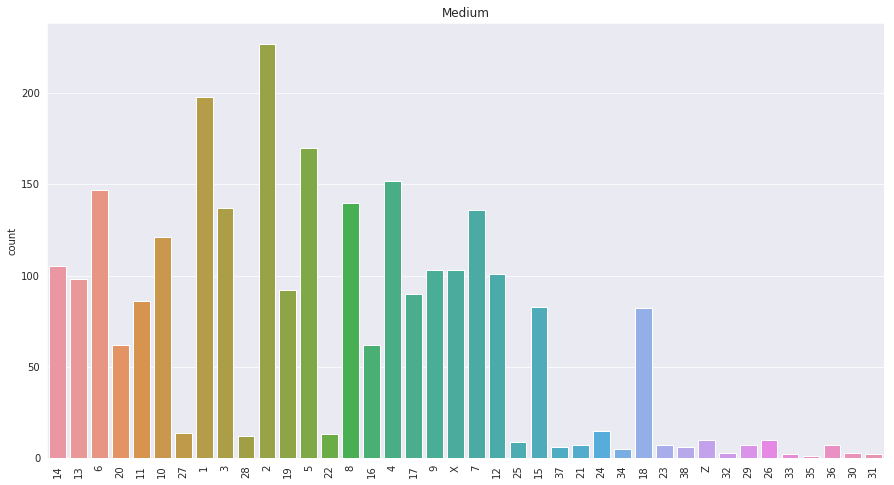

In [21]:
ser = df_dict["Medium"]["Sequence-1-Chromosome"].append(df_dict["Medium"]["Sequence-2-Chromosome"])
plt.figure(figsize=(15,8))
ax = sb.countplot(x=ser)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Medium")

In [22]:
for mutation_level in mutation_levels:
    df_dict[mutation_level] = pd.get_dummies(df_dict[mutation_level] ,prefix=['Seq-1-Biotype'],columns=['Sequence-1-Transcript-Biotype'], drop_first=True)
    df_dict[mutation_level] = pd.get_dummies(df_dict[mutation_level] ,prefix=['Seq-2-Biotype'],columns=['Sequence-2-Transcript-Biotype'], drop_first=True)

In [23]:
pd.options.display.max_columns = 100

In [24]:
df_dict["Low"]

,Is_Ohnolog,Is_Paralog,Sequence-1,Sequence-1 GC,Sequence-1 Id,Sequence-1 Length,Sequence-1-Transcript Id,Sequence-2,Sequence-2 GC,Sequence-2 Id,Sequence-2 Length,Sequence-2-Transcript Id,Species,Sequence-1-Transcript-Version,Sequence-2-Transcript-Version,Sequence-1-Chromosome,Sequence-2-Chromosome,Percent Identical Matches_High,Aligment Length_High,Nr Mismatch_High,Nr Gap Open_High,Evalue_High,Bit Score_High,Percent Identical Matches_Medium,Aligment Length_Medium,Nr Mismatch_Medium,Nr Gap Open_Medium,Evalue_Medium,Bit Score_Medium,Percent Identical Matches_Low,Aligment Length_Low,Nr Mismatch_Low,Nr Gap Open_Low,Evalue_Low,Bit Score_Low,Percent Identical Matches_Total,Aligment Length_Total,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Sequence-1-Mutated,Sequence-1 Length-Mutated,Sequence-1 GC-Mutated,Sequence-2-Mutated,Sequence-2 Length-Mutated,Sequence-2 GC-Mutated,Mutated_Sequence_Nr,Percent Identical Matches_High_M,Aligment Length_High_M,Nr Mismatch_High_M,Nr Gap Open_High_M,Evalue_High_M,Bit Score_High_M,Percent Identical Matches_Medium_M,Aligment Length_Medium_M,Nr Mismatch_Medium_M,Nr Gap Open_Medium_M,Evalue_Medium_M,Bit Score_Medium_M,Percent Identical Matches_Low_M,Aligment Length_Low_M,Nr Mismatch_Low_M,Nr Gap Open_Low_M,Evalue_Low_M,Bit Score_Low_M,Percent Identical Matches_Total_M,Aligment Length_Total_M,Nr Mismatch_Total_M,Nr Gap Open_Total_M,Evalue_Total_M,Bit Score_Total_M,Nr Hits_M,Seq-1-Biotype_protein_coding,Seq-2-Biotype_protein_coding
0,1,0.0,CGGTGGCAGGTTCTGGGGCAGCTGCTGCAGTCCGTAGCCCCATGGT...,0.485878,ENSSSCG00000009766,2974,ENSSSCT00000010708,GTGCAGAGCCGGGAGTGCCGAGCGGAGCCGCGACGCGTGCAGCCAA...,0.655055,ENSSSCG00000012890,2641,ENSSSCT00000014092,Pig,3,2,14,2,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,79.139500,96.250000,18.500000,1.000000,1.125000e-04,69.650000,98.888833,12.166667,0.000000,0.166667,1.961667,22.333333,90.989100,45.800000,7.400000,0.500000,1.177045e+00,41.260000,10,CGGTGGCAGGTTCTGGGGCAGCTGCTGCAGTCCGTAGCCCCATGGT...,2917,0.489887,GTGCAGAGCCGGGAGTGCCGAGCGGAGCCGCGACGCGTGCAGCCAA...,2641,0.655055,1,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,80.943000,96.750000,17.750000,1.000000,2.402500e-05,74.800000,98.245667,12.833333,0.333333,0.000000,1.545000,22.950000,91.324600,46.400000,7.300000,0.400000,9.270096e-01,43.690000,10,1,1
1,1,0.0,ATGGCTCGCTTCGGGGAGGCGGTGGTCGTTGGCAGACCAGGCTCAG...,0.526484,ENSRNOG00000002863,6891,ENSRNOT00000003928,TGTTCTGCAGGGTCTCCCTTTGCTCGTGCCAGCCTCAAGAGTGGGA...,0.524580,ENSRNOG00000004560,8279,ENSRNOT00000048945,Rat,7,4,13,3,75.6870,1427.0,308.5,29.5,3.040000e-119,658.0,78.431000,51.000000,11.000000,0.000000,3.000000e-03,34.400000,97.255333,14.222222,0.333333,0.111111,3.505556,24.722222,94.304810,150.523810,30.190476,2.904762,3.004905e+00,85.495238,21,ATGGCTCGCTTCGGGGAGGCGGTGGTCGTTGGCAGACCAGGCTCAG...,6891,0.526484,TGTTCTGCAGGGTCTCCCTTTGCTCGTGCCAGCCTCAAGAGTGGGA...,8089,0.524169,2,74.9295,986.0,211.0,25.0,5.200000e-87,416.0,82.235800,84.000000,13.200000,2.000000,6.038361e-04,66.040000,98.079632,13.736842,0.263158,0.052632,3.309474,24.647368,93.251962,102.038462,18.961538,2.346154,2.418578e+00,62.711538,26,1,1
2,1,0.0,GCGGCGGCCGTTGAGGGACCGTTGGGGCGGGCGGCGGCGGCGGCGG...,0.588968,ENSSSCG00000022545,2248,ENSSSCT00000032084,GGAGAATTAGTCCGAGTGGAGCGAGCGAGCTGAGTGGTTGTGTGGT...,0.378144,ENSSSCG00000008433,1153,ENSSSCT00000009234,Pig,1,2,6,3,81.0150,453.0,86.0,0.0,4.660000e-103,361.0,100.000000,15.000000,0.000000,0.000000,5.000000e-03,28.800000,100.000000,14.000000,0.000000,0.000000,0.019000,27.000000,93.671667,160.666667,28.666667,0.000000,8.000000e-03,138.933333,3,GCGGCGGCCGTTGAGGGACCGTTGGGGCGGGCGGCGGCGGCGGCGG...,2141,0.583372,GGAGAATTAGTCCGAGTGGAGCGAGCGAGCTGAGTGGTTGTGTGGT...,1153,0.378144,1,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,84.835750,83.750000,15.000000,0.000000,2.122527e-06,72.575000,100.000000,14.000000,0.000000,0.000000,0.018000,27.000000,87.868600,69.800000,12.000000,0.000000,3.601698e-03,63.460000,5,1,1
3,1,0.0,ATGTATTCACTGCTCTCCGCCTGCACTTGCCTATGTTTACATTTCC...,0.498397,ENSGA

In [27]:
def get_embeddings(kmer,kind):    
    df_emb = {}
    if(kind != ""):
        kind = "_" + kind   
    for mutation_level in mutation_levels:
        df_emb[mutation_level] = []
        df_emb[mutation_level].append(pd.read_pickle(train_filepath + working_level + "/embeddings_dna2vec/mutated/"  + "ohnologs-" + "1-vec-"+ str(kmer) + "kmer-" + mutation_level + ".pkl"))
        df_emb[mutation_level].append(pd.read_pickle(train_filepath + working_level + "/embeddings_dna2vec/mutated/" + "ohnologs-" + "2-vec-"+ str(kmer) + "kmer-" + mutation_level + ".pkl"))
    return df_emb
    
def get_embeddings_mutated(kmer):    
    df_emb = {}   
    for mutation_level in mutation_levels:
        df_emb[mutation_level] = [] 
        df_emb[mutation_level].append(pd.read_pickle(train_filepath + working_level + "/embeddings_dna2vec/mutated/" + "m_ohnologs-" + "1-vec-"+ str(kmer) + "kmer-" + mutation_level + ".pkl"))
        df_emb[mutation_level].append(pd.read_pickle(train_filepath + working_level + "/embeddings_dna2vec/mutated/" + "m_ohnologs-" + "2-vec-"+ str(kmer) + "kmer-" + mutation_level + ".pkl"))
    return df_emb
    
kmer_chosen = 8
type_chosen = "cdna"
df_emb_dict = get_embeddings(kmer_chosen,type_chosen)
df_emb_dict["Low"][0].head()

,Embedding1_0,Embedding1_1,Embedding1_2,Embedding1_3,Embedding1_4,Embedding1_5,Embedding1_6,Embedding1_7,Embedding1_8,Embedding1_9,Embedding1_10,Embedding1_11,Embedding1_12,Embedding1_13,Embedding1_14,Embedding1_15,Embedding1_16,Embedding1_17,Embedding1_18,Embedding1_19,Embedding1_20,Embedding1_21,Embedding1_22,Embedding1_23,Embedding1_24,Embedding1_25,Embedding1_26,Embedding1_27,Embedding1_28,Embedding1_29,Embedding1_30,Embedding1_31,Embedding1_32,Embedding1_33,Embedding1_34,Embedding1_35,Embedding1_36,Embedding1_37,Embedding1_38,Embedding1_39,Embedding1_40,Embedding1_41,Embedding1_42,Embedding1_43,Embedding1_44,Embedding1_45,Embedding1_46,Embedding1_47,Embedding1_48,Embedding1_49,Embedding1_50,Embedding1_51,Embedding1_52,Embedding1_53,Embedding1_54,Embedding1_55,Embedding1_56,Embedding1_57,Embedding1_58,Embedding1_59,Embedding1_60,Embedding1_61,Embedding1_62,Embedding1_63,Embedding1_64,Embedding1_65,Embedding1_66,Embedding1_67,Embedding1_68,Embedding1_69,Embedding1_70,Embedding1_71,Embedding1_72,Embedding1_73,Embedding1_74,Embedding1_75,Embedding1_76,Embedding1_77,Embedding1_78,Embedding1_79,Embedding1_80,Embedding1_81,Embedding1_82,Embedding1_83,Embedding1_84,Embedding1_85,Embedding1_86,Embedding1_87,Embedding1_88,Embedding1_89,Embedding1_90,Embedding1_91,Embedding1_92,Embedding1_93,Embedding1_94,Embedding1_95,Embedding1_96,Embedding1_97,Embedding1_98,Embedding1_99
0,-44.596029,-61.756636,10.059460,36.134568,24.379887,-81.081434,48.220245,26.109957,91.498196,-0.582015,-4.878224,7.341696,109.851493,-4.764270,-61.252762,-21.982588,-31.336999,76.221157,-28.537919,11.683646,20.226514,26.841534,30.487620,14.663346,44.117285,1.739049,19.430651,22.408567,18.307125,5.600588,21.513356,2.133028,-40.746471,-2.149905,31.594609,-0.448735,-82.098433,-50.050171,60.728256,54.166136,75.641512,16.143310,-17.114937,-91.771441,-36.521719,-88.674611,87.889322,-32.763288,68.394791,13.173052,-30.466923,-64.935757,-23.832881,-16.318945,18.254529,-59.047045,-13.901823,-26.389674,24.615046,-102.979988,60.960671,-65.073292,-36.974051,45.575335,-33.013152,-90.379125,38.266373,84.479502,106.297781,-31.537217,14.143117,130.747169,13.227457,-74.602234,-40.594009,-25.850750,-17.205265,95.473723,-95.602250,-26.166135,-43.153120,46.942004,-4.819460,46.440186,-8.218886,73.755236,52.174314,66.858954,-53.392398,39.349481,-7.474908,0.067471,-94.353768,-7.527687,-124.497870,15.390788,-91.922412,0.732603,0.177474,-113.270618
1,80.997234,-164.428671,11.611871,-11.995442,38.196104,-137.885649,221.601906,63.859184,134.945870,-94.679555,132.932355,-82.130369,60.095069,27.626892,-127.443956,164.972402,-39.693013,-47.528481,-142.302760,117.723502,-17.535567,163.248202,-7.092365,-22.392439,0.426470,29.942456,-2.296150,-41.822479,83.479686,-27.758057,163.931048,25.643193,-106.121255,-89.526658,48.583995,-50.384239,-185.171507,-94.088830,164.437671,172.486504,218.841403,80.063293,-11.559797,-171.968447,-95.240553,23.088207,180.220334,98.024903,128.259304,110.341283,-185.798419,-197.006159,-201.808207,-147.215505,30.855535,-136.711321,-62.282246,-17.070420,-27.415279,-243.074151,176.052261,2.155553,-120.331955,258.753014,-248.272128,-63.177786,-32.748312,146.168344,51.924844,-48.112287,-34.907121,70.685748,80.165667,-45.373566,-84.591897,-112.028979,-99.163013,-50.240417,-94.336449,-175.710435,-117.104551,-129.323103,-84.803948,204.696050,29.524171,130.063388,15.397563,136.118713,72.909936,102.850557,17.407122,31.330681,-251.195289,-5.860897,-221.245864,24.617813,-255.533832,-13.725622,93.337069,-202.745104
2,-16.512792,-45.387001,-1.135553,18.020396,27.439804,-46.499858,40.632111,5.028233,66.191693,-7.862134,22.556074,-20.101909,88.957724,4.168818,-49.937778,-32.171065,-17.431308,30.855307,-7.062021,4.663983,20.540676,13.068220,5.532960,24.945947,39.563281,5.706797,17.322910,5.642770,27.851470,-20.886066,-7.884178,11.309947,-48.198769,-4.264288,23.356781,-27.467319,-48.021373,-22.183817,37.757518,56.664184,71.853335,12.580492,-27.821111,-66.367485,-41.233120,-65.608042,46

In [28]:
df_emb_dict["High"][0].head()

,Embedding1_0,Embedding1_1,Embedding1_2,Embedding1_3,Embedding1_4,Embedding1_5,Embedding1_6,Embedding1_7,Embedding1_8,Embedding1_9,Embedding1_10,Embedding1_11,Embedding1_12,Embedding1_13,Embedding1_14,Embedding1_15,Embedding1_16,Embedding1_17,Embedding1_18,Embedding1_19,Embedding1_20,Embedding1_21,Embedding1_22,Embedding1_23,Embedding1_24,Embedding1_25,Embedding1_26,Embedding1_27,Embedding1_28,Embedding1_29,Embedding1_30,Embedding1_31,Embedding1_32,Embedding1_33,Embedding1_34,Embedding1_35,Embedding1_36,Embedding1_37,Embedding1_38,Embedding1_39,Embedding1_40,Embedding1_41,Embedding1_42,Embedding1_43,Embedding1_44,Embedding1_45,Embedding1_46,Embedding1_47,Embedding1_48,Embedding1_49,Embedding1_50,Embedding1_51,Embedding1_52,Embedding1_53,Embedding1_54,Embedding1_55,Embedding1_56,Embedding1_57,Embedding1_58,Embedding1_59,Embedding1_60,Embedding1_61,Embedding1_62,Embedding1_63,Embedding1_64,Embedding1_65,Embedding1_66,Embedding1_67,Embedding1_68,Embedding1_69,Embedding1_70,Embedding1_71,Embedding1_72,Embedding1_73,Embedding1_74,Embedding1_75,Embedding1_76,Embedding1_77,Embedding1_78,Embedding1_79,Embedding1_80,Embedding1_81,Embedding1_82,Embedding1_83,Embedding1_84,Embedding1_85,Embedding1_86,Embedding1_87,Embedding1_88,Embedding1_89,Embedding1_90,Embedding1_91,Embedding1_92,Embedding1_93,Embedding1_94,Embedding1_95,Embedding1_96,Embedding1_97,Embedding1_98,Embedding1_99
0,-44.596029,-61.756636,10.059460,36.134568,24.379887,-81.081434,48.220245,26.109957,91.498196,-0.582015,-4.878224,7.341696,109.851493,-4.764270,-61.252762,-21.982588,-31.336999,76.221157,-28.537919,11.683646,20.226514,26.841534,30.487620,14.663346,44.117285,1.739049,19.430651,22.408567,18.307125,5.600588,21.513356,2.133028,-40.746471,-2.149905,31.594609,-0.448735,-82.098433,-50.050171,60.728256,54.166136,75.641512,16.143310,-17.114937,-91.771441,-36.521719,-88.674611,87.889322,-32.763288,68.394791,13.173052,-30.466923,-64.935757,-23.832881,-16.318945,18.254529,-59.047045,-13.901823,-26.389674,24.615046,-102.979988,60.960671,-65.073292,-36.974051,45.575335,-33.013152,-90.379125,38.266373,84.479502,106.297781,-31.537217,14.143117,130.747169,13.227457,-74.602234,-40.594009,-25.850750,-17.205265,95.473723,-95.602250,-26.166135,-43.153120,46.942004,-4.819460,46.440186,-8.218886,73.755236,52.174314,66.858954,-53.392398,39.349481,-7.474908,0.067471,-94.353768,-7.527687,-124.497870,15.390788,-91.922412,0.732603,0.177474,-113.270618
1,80.997234,-164.428671,11.611871,-11.995442,38.196104,-137.885649,221.601906,63.859184,134.945870,-94.679555,132.932355,-82.130369,60.095069,27.626892,-127.443956,164.972402,-39.693013,-47.528481,-142.302760,117.723502,-17.535567,163.248202,-7.092365,-22.392439,0.426470,29.942456,-2.296150,-41.822479,83.479686,-27.758057,163.931048,25.643193,-106.121255,-89.526658,48.583995,-50.384239,-185.171507,-94.088830,164.437671,172.486504,218.841403,80.063293,-11.559797,-171.968447,-95.240553,23.088207,180.220334,98.024903,128.259304,110.341283,-185.798419,-197.006159,-201.808207,-147.215505,30.855535,-136.711321,-62.282246,-17.070420,-27.415279,-243.074151,176.052261,2.155553,-120.331955,258.753014,-248.272128,-63.177786,-32.748312,146.168344,51.924844,-48.112287,-34.907121,70.685748,80.165667,-45.373566,-84.591897,-112.028979,-99.163013,-50.240417,-94.336449,-175.710435,-117.104551,-129.323103,-84.803948,204.696050,29.524171,130.063388,15.397563,136.118713,72.909936,102.850557,17.407122,31.330681,-251.195289,-5.860897,-221.245864,24.617813,-255.533832,-13.725622,93.337069,-202.745104
2,-16.512792,-45.387001,-1.135553,18.020396,27.439804,-46.499858,40.632111,5.028233,66.191693,-7.862134,22.556074,-20.101909,88.957724,4.168818,-49.937778,-32.171065,-17.431308,30.855307,-7.062021,4.663983,20.540676,13.068220,5.532960,24.945947,39.563281,5.706797,17.322910,5.642770,27.851470,-20.886066,-7.884178,11.309947,-48.198769,-4.264288,23.356781,-27.467319,-48.021373,-22.183817,37.757518,56.664184,71.853335,12.580492,-27.821111,-66.367485,-41.233120,-65.608042,46

In [29]:
df_emb_dict_mutated = get_embeddings_mutated(kmer_chosen)

In [30]:

df_emb_dict_mutated["High"][0].head()

,M_Embedding1_0,M_Embedding1_1,M_Embedding1_2,M_Embedding1_3,M_Embedding1_4,M_Embedding1_5,M_Embedding1_6,M_Embedding1_7,M_Embedding1_8,M_Embedding1_9,M_Embedding1_10,M_Embedding1_11,M_Embedding1_12,M_Embedding1_13,M_Embedding1_14,M_Embedding1_15,M_Embedding1_16,M_Embedding1_17,M_Embedding1_18,M_Embedding1_19,M_Embedding1_20,M_Embedding1_21,M_Embedding1_22,M_Embedding1_23,M_Embedding1_24,M_Embedding1_25,M_Embedding1_26,M_Embedding1_27,M_Embedding1_28,M_Embedding1_29,M_Embedding1_30,M_Embedding1_31,M_Embedding1_32,M_Embedding1_33,M_Embedding1_34,M_Embedding1_35,M_Embedding1_36,M_Embedding1_37,M_Embedding1_38,M_Embedding1_39,M_Embedding1_40,M_Embedding1_41,M_Embedding1_42,M_Embedding1_43,M_Embedding1_44,M_Embedding1_45,M_Embedding1_46,M_Embedding1_47,M_Embedding1_48,M_Embedding1_49,M_Embedding1_50,M_Embedding1_51,M_Embedding1_52,M_Embedding1_53,M_Embedding1_54,M_Embedding1_55,M_Embedding1_56,M_Embedding1_57,M_Embedding1_58,M_Embedding1_59,M_Embedding1_60,M_Embedding1_61,M_Embedding1_62,M_Embedding1_63,M_Embedding1_64,M_Embedding1_65,M_Embedding1_66,M_Embedding1_67,M_Embedding1_68,M_Embedding1_69,M_Embedding1_70,M_Embedding1_71,M_Embedding1_72,M_Embedding1_73,M_Embedding1_74,M_Embedding1_75,M_Embedding1_76,M_Embedding1_77,M_Embedding1_78,M_Embedding1_79,M_Embedding1_80,M_Embedding1_81,M_Embedding1_82,M_Embedding1_83,M_Embedding1_84,M_Embedding1_85,M_Embedding1_86,M_Embedding1_87,M_Embedding1_88,M_Embedding1_89,M_Embedding1_90,M_Embedding1_91,M_Embedding1_92,M_Embedding1_93,M_Embedding1_94,M_Embedding1_95,M_Embedding1_96,M_Embedding1_97,M_Embedding1_98,M_Embedding1_99
0,-39.472377,-44.192033,9.964507,31.088967,24.663256,-68.922827,43.415773,27.335079,80.407817,-7.771471,3.716424,3.200234,94.611065,3.733882,-42.887510,-22.560194,-31.942415,57.465588,-19.091943,19.534109,18.276430,15.239112,19.853793,9.001456,36.055034,-1.187031,24.317165,5.937479,22.962461,4.584542,17.470043,1.823762,-43.658755,3.100339,27.057860,-4.765310,-75.418080,-38.781221,59.228278,40.595414,59.176029,12.527117,-18.790938,-74.384039,-24.483657,-70.847002,71.972016,-35.304348,53.469336,17.569834,-30.026947,-54.708528,-3.681022,-25.706051,4.505672,-50.960838,-8.072585,-21.280519,25.526726,-82.570154,48.787152,-44.248112,-35.346441,45.143228,-31.147414,-67.253684,17.560089,76.248398,85.785036,-35.561299,-7.482954,109.749439,-2.141410,-64.222296,-39.827946,-13.137696,-0.145485,78.407549,-80.773957,-29.091224,-47.337029,45.403120,4.754661,48.764046,-10.325510,59.225691,37.044310,47.362126,-42.510580,35.046482,-7.528718,-0.024174,-73.955010,-3.313923,-105.237071,13.568430,-79.195485,1.887270,-2.746446,-92.302292
1,64.836815,-144.695733,18.905258,0.423586,30.639172,-114.272871,189.066898,53.640197,130.118663,-82.879873,100.338932,-87.248561,50.281631,24.018672,-126.498482,150.882108,-25.303216,-39.959193,-120.875232,113.926013,-22.979970,137.000420,-11.445020,-11.864015,2.053171,42.326331,10.732895,-30.308317,81.123020,-1.672169,136.313093,37.951094,-88.775694,-87.064754,28.979326,-15.687837,-171.525255,-101.938162,153.336427,152.601170,198.747159,80.031172,-3.562740,-148.217100,-78.967991,18.494325,154.724188,92.102659,136.624319,98.466964,-158.488164,-173.685217,-197.544551,-130.708080,28.151526,-127.455744,-42.778347,-16.239354,-21.971509,-223.614823,166.111056,2.455082,-119.954004,231.421092,-217.566226,-46.698675,-16.064819,123.101205,54.218925,-56.809741,-10.830830,57.138867,55.546983,-52.199226,-66.958048,-109.401820,-93.103632,-50.506019,-73.369057,-181.978495,-118.164911,-112.563010,-76.842001,160.668452,29.892243,92.087234,5.156860,122.615498,63.136086,81.146793,-0.463426,10.666150,-198.573426,-8.572368,-192.473512,17.223968,-239.440352,-5.877865,79.285015,-197.588224
2,-18.555755,-37.171268,13.446967,5.479718,25.688694,-36.043900,36.470430,15.809576,59.245241,-5.827751,20.012819,-23.597893,67.849452,-4.289003,-51.361208,-23.389985,-19.460175,28.762162,-12.423073,2.410257,17.302137,12.065011,6.451140,19.219987,28.037599,8.145864,18.418386,11.723435,14.8600

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
for mutation_level in mutation_levels:
    curr_df = df_emb_dict[mutation_level]
    cosine_similarity_list = []
    for i in range(0,len(curr_df[0].values)):    
        cosine_similarity_list.append(cosine_similarity([curr_df[0].values[i]], [curr_df[1].values[i]])[0][0])            
    df_dict[mutation_level]["Cosine_Similarity"] = cosine_similarity_list             

In [32]:
df_dict[mutation_level].head()

,Is_Ohnolog,Is_Paralog,Sequence-1,Sequence-1 GC,Sequence-1 Id,Sequence-1 Length,Sequence-1-Transcript Id,Sequence-2,Sequence-2 GC,Sequence-2 Id,Sequence-2 Length,Sequence-2-Transcript Id,Species,Sequence-1-Transcript-Version,Sequence-2-Transcript-Version,Sequence-1-Chromosome,Sequence-2-Chromosome,Percent Identical Matches_High,Aligment Length_High,Nr Mismatch_High,Nr Gap Open_High,Evalue_High,Bit Score_High,Percent Identical Matches_Medium,Aligment Length_Medium,Nr Mismatch_Medium,Nr Gap Open_Medium,Evalue_Medium,Bit Score_Medium,Percent Identical Matches_Low,Aligment Length_Low,Nr Mismatch_Low,Nr Gap Open_Low,Evalue_Low,Bit Score_Low,Percent Identical Matches_Total,Aligment Length_Total,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Sequence-1-Mutated,Sequence-1 Length-Mutated,Sequence-1 GC-Mutated,Sequence-2-Mutated,Sequence-2 Length-Mutated,Sequence-2 GC-Mutated,Mutated_Sequence_Nr,Percent Identical Matches_High_M,Aligment Length_High_M,Nr Mismatch_High_M,Nr Gap Open_High_M,Evalue_High_M,Bit Score_High_M,Percent Identical Matches_Medium_M,Aligment Length_Medium_M,Nr Mismatch_Medium_M,Nr Gap Open_Medium_M,Evalue_Medium_M,Bit Score_Medium_M,Percent Identical Matches_Low_M,Aligment Length_Low_M,Nr Mismatch_Low_M,Nr Gap Open_Low_M,Evalue_Low_M,Bit Score_Low_M,Percent Identical Matches_Total_M,Aligment Length_Total_M,Nr Mismatch_Total_M,Nr Gap Open_Total_M,Evalue_Total_M,Bit Score_Total_M,Nr Hits_M,Seq-1-Biotype_protein_coding,Seq-2-Biotype_protein_coding,Cosine_Similarity
0,1,0.0,CGGTGGCAGGTTCTGGGGCAGCTGCTGCAGTCCGTAGCCCCATGGT...,0.485878,ENSSSCG00000009766,2974,ENSSSCT00000010708,GTGCAGAGCCGGGAGTGCCGAGCGGAGCCGCGACGCGTGCAGCCAA...,0.655055,ENSSSCG00000012890,2641,ENSSSCT00000014092,Pig,3,2,14,2,0.000,0.0,0.0,0.0,0.000000e+00,0.0,79.1395,96.25,18.5,1.0,1.125000e-04,69.65,98.888833,12.166667,0.000000,0.166667,1.961667,22.333333,90.989100,45.800000,7.400000,0.500000,1.177045,41.260000,10,CGGTGGCAGCTTCTGGGGCAGCTACTGCAGTCCGTAGCTCCATGGT...,2495,0.493387,GTGCAGAGCCGGGAGTGCCGTGCATGCCGGAAGTGCCGTGCAGAGC...,2460,0.637805,0,0.0,0.0,0.0,0.0,0.0,0.0,80.4880,41.000000,8.000000,0.0,1.000000e-03,32.500000,94.510800,14.600000,0.600000,0.400000,1.800000,21.780000,92.173667,19.000000,1.833333,0.333333,1.500167,23.566667,6,1,1,0.862135
1,1,0.0,ATGGCTCGCTTCGGGGAGGCGGTGGTCGTTGGCAGACCAGGCTCAG...,0.526484,ENSRNOG00000002863,6891,ENSRNOT00000003928,TGTTCTGCAGGGTCTCCCTTTGCTCGTGCCAGCCTCAAGAGTGGGA...,0.524580,ENSRNOG00000004560,8279,ENSRNOT00000048945,Rat,7,4,13,3,75.687,1427.0,308.5,29.5,3.040000e-119,658.0,78.4310,51.00,11.0,0.0,3.000000e-03,34.40,97.255333,14.222222,0.333333,0.111111,3.505556,24.722222,94.304810,150.523810,30.190476,2.904762,3.004905,85.495238,21,ATGGCTCGCTTCGGGGAGGCGGTGGTGGTTGCTTTGTACAACCCCA...,6151,0.522679,TGTTCTGCGGGGTCTCCCTTTGCTCGTGGGAAAACCGACGTTCCTT...,7448,0.520945,0,0.0,0.0,0.0,0.0,0.0,0.0,86.0715,55.333333,7.833333,1.5,1.922507e-04,47.583333,94.490182,16.727273,0.909091,0.363636,3.122364,24.463636,91.518882,30.352941,3.352941,0.764706,2.020421,32.623529,17,1,1,0.991308
2,1,0.0,GCGGCGGCCGTTGAGGGACCGTTGGGGCGGGCGGCGGCGGCGGCGG...,0.588968,ENSSSCG00000022545,2248,ENSSSCT00000032084,GGAGAATTAGTCCGAGTGGAGCGAGCGAGCTGAGTGGTTGTGTGGT...,0.378144,ENSSSCG00000008433,1153,ENSSSCT00000009234,Pig,1,2,6,3,81.015,453.0,86.0,0.0,4.660000e-103,361.0,100.0000,15.00,0.0,0.0,5.000000e-03,28.80,100.000000,14.000000,0.000000,0.000000,0.019000,27.000000,93.671667,160.666667,28.666667,0.000000,0.008000,138.933333,3,TCGGCGGCCGTTGAGGGACCGTTGTGGCGGGCGGCGGCGGCGGCGG...,1950,0.578462,GGAGAATTAGTCCGAGTGGAGCGAGTGAGCTGAGTTTAAGATTGCA...,1015,0.373399,0,0.0,0.0,0.0,0.0,0.0,0.0,74.7660,107.000000,27.000000,0.0,3.140000e-09,49.100000,88.358333,21.666667,2.000000,0.666667,0.086000,25.133333,84.960250,43.000000,8.250000,0.500000,0.064500,31.125000,4,1,1,0.809499
3,1,0.0,ATGTATTCACTGCTCTCCGCCTGCACTTGCCTATGTTTACATTTCC...,0.498397,ENSGALG00000002203,624,ENSGALT00000055066,ATGGTGTGTCGTATATTTTTTAATTTCCTAAAGGTAACTGTTCAGT...,0.521502,ENSGALG0000000770

In [33]:
for mutation_level in mutation_levels:
    df_dict[mutation_level] = pd.get_dummies(df_dict[mutation_level] ,prefix=['Specie'],columns=['Species'])
df_dict["Low"].head()

,Is_Ohnolog,Is_Paralog,Sequence-1,Sequence-1 GC,Sequence-1 Id,Sequence-1 Length,Sequence-1-Transcript Id,Sequence-2,Sequence-2 GC,Sequence-2 Id,Sequence-2 Length,Sequence-2-Transcript Id,Sequence-1-Transcript-Version,Sequence-2-Transcript-Version,Sequence-1-Chromosome,Sequence-2-Chromosome,Percent Identical Matches_High,Aligment Length_High,Nr Mismatch_High,Nr Gap Open_High,Evalue_High,Bit Score_High,Percent Identical Matches_Medium,Aligment Length_Medium,Nr Mismatch_Medium,Nr Gap Open_Medium,Evalue_Medium,Bit Score_Medium,Percent Identical Matches_Low,Aligment Length_Low,Nr Mismatch_Low,Nr Gap Open_Low,Evalue_Low,Bit Score_Low,Percent Identical Matches_Total,Aligment Length_Total,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Sequence-1-Mutated,Sequence-1 Length-Mutated,Sequence-1 GC-Mutated,Sequence-2-Mutated,Sequence-2 Length-Mutated,Sequence-2 GC-Mutated,Mutated_Sequence_Nr,Percent Identical Matches_High_M,Aligment Length_High_M,Nr Mismatch_High_M,Nr Gap Open_High_M,Evalue_High_M,Bit Score_High_M,Percent Identical Matches_Medium_M,Aligment Length_Medium_M,Nr Mismatch_Medium_M,Nr Gap Open_Medium_M,Evalue_Medium_M,Bit Score_Medium_M,Percent Identical Matches_Low_M,Aligment Length_Low_M,Nr Mismatch_Low_M,Nr Gap Open_Low_M,Evalue_Low_M,Bit Score_Low_M,Percent Identical Matches_Total_M,Aligment Length_Total_M,Nr Mismatch_Total_M,Nr Gap Open_Total_M,Evalue_Total_M,Bit Score_Total_M,Nr Hits_M,Seq-1-Biotype_protein_coding,Seq-2-Biotype_protein_coding,Cosine_Similarity,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat
0,1,0.0,CGGTGGCAGGTTCTGGGGCAGCTGCTGCAGTCCGTAGCCCCATGGT...,0.485878,ENSSSCG00000009766,2974,ENSSSCT00000010708,GTGCAGAGCCGGGAGTGCCGAGCGGAGCCGCGACGCGTGCAGCCAA...,0.655055,ENSSSCG00000012890,2641,ENSSSCT00000014092,3,2,14,2,0.000,0.0,0.0,0.0,0.000000e+00,0.0,79.1395,96.25,18.5,1.0,1.125000e-04,69.65,98.888833,12.166667,0.000000,0.166667,1.961667,22.333333,90.989100,45.800000,7.400000,0.500000,1.177045,41.260000,10,CGGTGGCAGGTTCTGGGGCAGCTGCTGCAGTCCGTAGCCCCATGGT...,2917,0.489887,GTGCAGAGCCGGGAGTGCCGAGCGGAGCCGCGACGCGTGCAGCCAA...,2641,0.655055,1,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,80.943000,96.750000,17.750000,1.0,2.402500e-05,74.800,98.245667,12.833333,0.333333,0.000000,1.545000,22.950000,91.324600,46.400000,7.300000,0.400000,0.927010,43.690000,10,1,1,0.862135,0,0,0,0,1,0
1,1,0.0,ATGGCTCGCTTCGGGGAGGCGGTGGTCGTTGGCAGACCAGGCTCAG...,0.526484,ENSRNOG00000002863,6891,ENSRNOT00000003928,TGTTCTGCAGGGTCTCCCTTTGCTCGTGCCAGCCTCAAGAGTGGGA...,0.524580,ENSRNOG00000004560,8279,ENSRNOT00000048945,7,4,13,3,75.687,1427.0,308.5,29.5,3.040000e-119,658.0,78.4310,51.00,11.0,0.0,3.000000e-03,34.40,97.255333,14.222222,0.333333,0.111111,3.505556,24.722222,94.304810,150.523810,30.190476,2.904762,3.004905,85.495238,21,ATGGCTCGCTTCGGGGAGGCGGTGGTCGTTGGCAGACCAGGCTCAG...,6891,0.526484,TGTTCTGCAGGGTCTCCCTTTGCTCGTGCCAGCCTCAAGAGTGGGA...,8089,0.524169,2,74.9295,986.0,211.0,25.0,5.200000e-87,416.0,82.235800,84.000000,13.200000,2.0,6.038361e-04,66.040,98.079632,13.736842,0.263158,0.052632,3.309474,24.647368,93.251962,102.038462,18.961538,2.346154,2.418578,62.711538,26,1,1,0.991308,0,0,0,0,0,1
2,1,0.0,GCGGCGGCCGTTGAGGGACCGTTGGGGCGGGCGGCGGCGGCGGCGG...,0.588968,ENSSSCG00000022545,2248,ENSSSCT00000032084,GGAGAATTAGTCCGAGTGGAGCGAGCGAGCTGAGTGGTTGTGTGGT...,0.378144,ENSSSCG00000008433,1153,ENSSSCT00000009234,1,2,6,3,81.015,453.0,86.0,0.0,4.660000e-103,361.0,100.0000,15.00,0.0,0.0,5.000000e-03,28.80,100.000000,14.000000,0.000000,0.000000,0.019000,27.000000,93.671667,160.666667,28.666667,0.000000,0.008000,138.933333,3,GCGGCGGCCGTTGAGGGACCGTTGGGGCGGGCGGCGGCGGCGGCGG...,2141,0.583372,GGAGAATTAGTCCGAGTGGAGCGAGCGAGCTGAGTGGTTGTGTGGT...,1153,0.378144,1,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,84.835750,83.750000,15.000000,0.0,2.122527e-06,72.575,100.000000,14.000000,0.000000,0.000000,0.018000,27.000000,87.868600,69.800000,12.000000,0.000000,0.003602,63.460000,5,1,1,0.809499,0,0,0,0,1,0
3,1,0.0,ATGTATTCACTGCTCTCCGCCTGCACTTGCCTATGTTTAC

## Start Designing

In [34]:
blast_columns = ["Percent Identical Matches","Aligment Length","Nr Mismatch","Nr Gap Open","Evalue","Bit Score"]

e_values_columns = ["Evalue_Total","Evalue_High","Evalue_Medium","Evalue_Low"]

blast_types = ["High","Medium","Low","Total"]
blast_col_Total = [i + "_Total" for i in blast_columns] 
blast_col_High = [i + "_High" for i in blast_columns]
blast_col_Medium = [i + "_Medium" for i in blast_columns]
blast_col_Low = [i + "_Low" for i in blast_columns]

blast_cols_levels = blast_col_High + blast_col_Medium + blast_col_Low
total_columns = (blast_col_High + blast_col_Medium + blast_col_Low + blast_col_Total + ["Nr Hits"])

total_columns_mutated = [i + "_M" for i in total_columns]

non_training_meta_features = ["Sequence-1","Sequence-2","Sequence-1 Id","Sequence-1-Transcript Id","Sequence-2 Id","Sequence-2-Transcript Id","Sequence-1-Transcript-Version","Sequence-2-Transcript-Version"]

non_training_meta_features_mutated = ["Sequence-1-Mutated","Sequence-2-Mutated"]

sequence_1_metadata = ["Sequence-1 GC","Sequence-1 Length","Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata = ["Sequence-2 GC","Sequence-2 Length","Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

sequence_1_metadata_diferential = ["Sequence-1 GC","Sequence-1 Length"]
sequence_2_metadata_diferential = ["Sequence-2 GC","Sequence-2 Length"]

sequence_1_metadata_categorical = ["Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata_categorical = ["Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

species_metadata = ["Specie_Dog","Specie_Human","Specie_Mouse","Specie_Pig","Specie_Rat"]

emb_size = 100
if(type_chosen == "cdna2"):
    emb_size = 200
embedding_1_cols = ["Embedding1_" + str(i) for i in range(0,emb_size)]
embedding_2_cols = ["Embedding2_" + str(i) for i in range(0,emb_size)]

embedding_1_cols_mutated = ["M_" + i for i in embedding_1_cols]
embedding_2_cols_mutated = ["M_" + i for i in embedding_2_cols]

In [35]:
## Ver los efectos de no normalizar las longitudes o tambien de como hacer el encoding de los Chromosomas
dataset_ohnologs = {}
for  mutation_level in mutation_levels:
    dataset_ohnologs[mutation_level] = df_dict[mutation_level].drop(non_training_meta_features + non_training_meta_features_mutated,axis=1)
    dataset_ohnologs[mutation_level] = dataset_ohnologs[mutation_level].drop(["Is_Paralog"],axis=1)

dataset_ohnologs["Low"].head()

,Is_Ohnolog,Sequence-1 GC,Sequence-1 Length,Sequence-2 GC,Sequence-2 Length,Sequence-1-Chromosome,Sequence-2-Chromosome,Percent Identical Matches_High,Aligment Length_High,Nr Mismatch_High,Nr Gap Open_High,Evalue_High,Bit Score_High,Percent Identical Matches_Medium,Aligment Length_Medium,Nr Mismatch_Medium,Nr Gap Open_Medium,Evalue_Medium,Bit Score_Medium,Percent Identical Matches_Low,Aligment Length_Low,Nr Mismatch_Low,Nr Gap Open_Low,Evalue_Low,Bit Score_Low,Percent Identical Matches_Total,Aligment Length_Total,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Sequence-1 Length-Mutated,Sequence-1 GC-Mutated,Sequence-2 Length-Mutated,Sequence-2 GC-Mutated,Mutated_Sequence_Nr,Percent Identical Matches_High_M,Aligment Length_High_M,Nr Mismatch_High_M,Nr Gap Open_High_M,Evalue_High_M,Bit Score_High_M,Percent Identical Matches_Medium_M,Aligment Length_Medium_M,Nr Mismatch_Medium_M,Nr Gap Open_Medium_M,Evalue_Medium_M,Bit Score_Medium_M,Percent Identical Matches_Low_M,Aligment Length_Low_M,Nr Mismatch_Low_M,Nr Gap Open_Low_M,Evalue_Low_M,Bit Score_Low_M,Percent Identical Matches_Total_M,Aligment Length_Total_M,Nr Mismatch_Total_M,Nr Gap Open_Total_M,Evalue_Total_M,Bit Score_Total_M,Nr Hits_M,Seq-1-Biotype_protein_coding,Seq-2-Biotype_protein_coding,Cosine_Similarity,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat
0,1,0.485878,2974,0.655055,2641,14,2,0.000,0.0,0.0,0.0,0.000000e+00,0.0,79.1395,96.25,18.5,1.0,1.125000e-04,69.65,98.888833,12.166667,0.000000,0.166667,1.961667,22.333333,90.989100,45.800000,7.400000,0.500000,1.177045,41.260000,10,2917,0.489887,2641,0.655055,1,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,80.943000,96.750000,17.750000,1.0,2.402500e-05,74.800,98.245667,12.833333,0.333333,0.000000,1.545000,22.950000,91.324600,46.400000,7.300000,0.400000,0.927010,43.690000,10,1,1,0.862135,0,0,0,0,1,0
1,1,0.526484,6891,0.524580,8279,13,3,75.687,1427.0,308.5,29.5,3.040000e-119,658.0,78.4310,51.00,11.0,0.0,3.000000e-03,34.40,97.255333,14.222222,0.333333,0.111111,3.505556,24.722222,94.304810,150.523810,30.190476,2.904762,3.004905,85.495238,21,6891,0.526484,8089,0.524169,2,74.9295,986.0,211.0,25.0,5.200000e-87,416.0,82.235800,84.000000,13.200000,2.0,6.038361e-04,66.040,98.079632,13.736842,0.263158,0.052632,3.309474,24.647368,93.251962,102.038462,18.961538,2.346154,2.418578,62.711538,26,1,1,0.991308,0,0,0,0,0,1
2,1,0.588968,2248,0.378144,1153,6,3,81.015,453.0,86.0,0.0,4.660000e-103,361.0,100.0000,15.00,0.0,0.0,5.000000e-03,28.80,100.000000,14.000000,0.000000,0.000000,0.019000,27.000000,93.671667,160.666667,28.666667,0.000000,0.008000,138.933333,3,2141,0.583372,1153,0.378144,1,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,84.835750,83.750000,15.000000,0.0,2.122527e-06,72.575,100.000000,14.000000,0.000000,0.000000,0.018000,27.000000,87.868600,69.800000,12.000000,0.000000,0.003602,63.460000,5,1,1,0.809499,0,0,0,0,1,0
3,1,0.498397,624,0.521502,4581,13,6,0.000,0.0,0.0,0.0,0.000000e+00,0.0,73.2170,171.50,44.0,2.0,1.000000e-03,53.75,100.000000,11.000000,0.000000,0.000000,0.980000,21.400000,91.072333,64.500000,14.666667,0.666667,0.653667,32.183333,6,624,0.498397,4437,0.521974,2,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,72.075000,265.000000,71.000000,1.0,2.000000e-17,76.800,100.000000,11.000000,0.000000,0.000000,0.950000,21.400000,94.415000,61.800000,14.200000,0.200000,0.760000,32.480000,5,1,1,0.927417,1,0,0,0,0,0
4,1,0.654913,2524,0.599177,3645,20,3,76.701,485.0,101.0,10.0,6.260000e-72,259.0,77.3235,126.00,27.5,1.0,1.585000e-10,75.00,99.047571,11.928571,0.071429,0.071429,2.481357,22.207143,95.177294,53.176471,9.235294,0.764706,2.043471,42.347059,17,2524,0.654913,3421,0.596025,2,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,79.355667,171.333333,35.333333,3.0,7.733333e-07,97.600,98.448412,12.529412,0.235294,0.058824,2.146471,22.505882,95.584500,36.350000,5.500000,0.500000,1.824500,33.770000,20,1,1,0.978822,0,1,0,0,0,0


In [36]:
for  mutation_level in mutation_levels:
    dataset_ohnologs[mutation_level].reset_index(inplace=True, drop=True)
    dataset_ohnologs[mutation_level] = pd.concat([dataset_ohnologs[mutation_level].drop(sequence_2_metadata,axis=1),df_emb_dict[mutation_level][0],df_emb_dict_mutated[mutation_level][0],dataset_ohnologs[mutation_level][sequence_2_metadata],df_emb_dict[mutation_level][1],df_emb_dict_mutated[mutation_level][1]],axis=1, sort=False)
dataset_ohnologs["Low"].head()

,Is_Ohnolog,Sequence-1 GC,Sequence-1 Length,Sequence-1-Chromosome,Percent Identical Matches_High,Aligment Length_High,Nr Mismatch_High,Nr Gap Open_High,Evalue_High,Bit Score_High,Percent Identical Matches_Medium,Aligment Length_Medium,Nr Mismatch_Medium,Nr Gap Open_Medium,Evalue_Medium,Bit Score_Medium,Percent Identical Matches_Low,Aligment Length_Low,Nr Mismatch_Low,Nr Gap Open_Low,Evalue_Low,Bit Score_Low,Percent Identical Matches_Total,Aligment Length_Total,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Sequence-1 Length-Mutated,Sequence-1 GC-Mutated,Sequence-2 Length-Mutated,Sequence-2 GC-Mutated,Mutated_Sequence_Nr,Percent Identical Matches_High_M,Aligment Length_High_M,Nr Mismatch_High_M,Nr Gap Open_High_M,Evalue_High_M,Bit Score_High_M,Percent Identical Matches_Medium_M,Aligment Length_Medium_M,Nr Mismatch_Medium_M,Nr Gap Open_Medium_M,Evalue_Medium_M,Bit Score_Medium_M,Percent Identical Matches_Low_M,Aligment Length_Low_M,Nr Mismatch_Low_M,Nr Gap Open_Low_M,...,M_Embedding2_50,M_Embedding2_51,M_Embedding2_52,M_Embedding2_53,M_Embedding2_54,M_Embedding2_55,M_Embedding2_56,M_Embedding2_57,M_Embedding2_58,M_Embedding2_59,M_Embedding2_60,M_Embedding2_61,M_Embedding2_62,M_Embedding2_63,M_Embedding2_64,M_Embedding2_65,M_Embedding2_66,M_Embedding2_67,M_Embedding2_68,M_Embedding2_69,M_Embedding2_70,M_Embedding2_71,M_Embedding2_72,M_Embedding2_73,M_Embedding2_74,M_Embedding2_75,M_Embedding2_76,M_Embedding2_77,M_Embedding2_78,M_Embedding2_79,M_Embedding2_80,M_Embedding2_81,M_Embedding2_82,M_Embedding2_83,M_Embedding2_84,M_Embedding2_85,M_Embedding2_86,M_Embedding2_87,M_Embedding2_88,M_Embedding2_89,M_Embedding2_90,M_Embedding2_91,M_Embedding2_92,M_Embedding2_93,M_Embedding2_94,M_Embedding2_95,M_Embedding2_96,M_Embedding2_97,M_Embedding2_98,M_Embedding2_99
0,1,0.485878,2974,14,0.000,0.0,0.0,0.0,0.000000e+00,0.0,79.1395,96.25,18.5,1.0,1.125000e-04,69.65,98.888833,12.166667,0.000000,0.166667,1.961667,22.333333,90.989100,45.800000,7.400000,0.500000,1.177045,41.260000,10,2917,0.489887,2641,0.655055,1,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,80.943000,96.750000,17.750000,1.0,2.402500e-05,74.800,98.245667,12.833333,0.333333,0.000000,...,-43.228983,-55.892773,-33.985768,4.387450,-7.294655,-57.750052,-41.853472,-52.793999,6.083148,-127.514539,22.601626,-32.945197,-47.350350,65.061024,-106.172972,-75.219974,15.857379,100.757228,62.901711,-72.314868,29.969826,145.511702,15.983050,-4.241682,-13.521298,-13.256344,-34.061542,48.089186,-60.823913,-34.487784,-57.993991,38.698584,4.550893,55.507933,-29.977542,46.399426,65.233929,82.065349,-64.971021,50.536974,38.566664,-19.088033,-101.457720,-26.108384,-95.276977,9.151727,-105.619513,19.387965,-20.697493,-89.212387
1,1,0.526484,6891,13,75.687,1427.0,308.5,29.5,3.040000e-119,658.0,78.4310,51.00,11.0,0.0,3.000000e-03,34.40,97.255333,14.222222,0.333333,0.111111,3.505556,24.722222,94.304810,150.523810,30.190476,2.904762,3.004905,85.495238,21,6891,0.526484,8089,0.524169,2,74.9295,986.0,211.0,25.0,5.200000e-87,416.0,82.235800,84.000000,13.200000,2.0,6.038361e-04,66.040,98.079632,13.736842,0.263158,0.052632,...,-183.377552,-253.855484,-254.476263,-187.489614,57.476109,-176.722683,-76.332608,-31.523599,-22.304195,-296.458104,214.152911,35.332697,-159.642378,294.707500,-315.373857,-45.092985,-30.289681,129.815900,67.642685,-54.654206,-35.413337,87.925086,77.596288,-60.045779,-72.885679,-134.929453,-115.629836,-60.483938,-114.050956,-232.520720,-156.854376,-131.419952,-66.936392,209.432678,47.338942,101.223360,-0.758809,152.261014,69.556839,158.217143,-15.067802,17.729464,-275.577731,17.886161,-220.752526,26.336635,-304.652799,5.484514,114.109713,-251.598912
2,1,0.588968,2248,6,81.015,453.0,86.0,0.0,4.660000e-103,361.0,100.0000,15.00,0.0,0.0,5.000000e-03,28.80,100.000000,14.000000,0.000000,0.000000,0.019000,27.000000,93.671667,160.666667,28.666667,0.000000,0.008000,138.933333,3,2141,0.583372,1153,0.378144,1,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,84.835750,83.750000,15.000000,0.0,2.122527

In [37]:
dataset_complete = {}

In [38]:
dataset_ohnologs["Low"]["Sequence-1-Chromosome"].unique()

array(['14', '13', '6', '20', '11', '10', '27', '1', '3', '28', '2', '19',
       '5', '22', '8', '16', '4', '17', '9', 'X', '7', '12', '25', '15',
       '37', '21', '24', '34', '18', '23', '38', 'Z', '32', '29', '26',
       '33', '35'], dtype=object)

In [39]:
seq1 = list(dataset_ohnologs["Low"]["Sequence-1-Chromosome"].unique())
seq2 = list(dataset_ohnologs["Low"]["Sequence-2-Chromosome"].unique())
chrm_values = list(set((seq1 + seq2)))
cleaned = [ int(x) for x in chrm_values if x.isdigit() ]
current_max = max(cleaned)
current_max

38

In [40]:
chromosome_dict = {}

for i in range(1,current_max+1):
    chromosome_dict[str(i)] = str(i)

chromosome_dict["X"] = str(current_max + 1)
chromosome_dict["Y"] = str(current_max + 2)
chromosome_dict["Z"] = str(current_max + 3)
chromosome_dict["Other"] = str(current_max + 4)

for  mutation_level in mutation_levels:

    dataset_ohnologs[mutation_level].loc[dataset_ohnologs[mutation_level]['Sequence-1-Chromosome'] == "X", 'Sequence-1-Chromosome'] = str(current_max + 1)
    dataset_ohnologs[mutation_level].loc[dataset_ohnologs[mutation_level]['Sequence-2-Chromosome'] == "X", 'Sequence-2-Chromosome'] = str(current_max + 1)

    dataset_ohnologs[mutation_level].loc[dataset_ohnologs[mutation_level]['Sequence-1-Chromosome'] == "Y", 'Sequence-1-Chromosome'] = str(current_max + 2)
    dataset_ohnologs[mutation_level].loc[dataset_ohnologs[mutation_level]['Sequence-2-Chromosome'] == "Y", 'Sequence-2-Chromosome'] = str(current_max + 2)

    dataset_ohnologs[mutation_level].loc[dataset_ohnologs[mutation_level]['Sequence-1-Chromosome'] == "Z", 'Sequence-1-Chromosome'] = str(current_max + 3)
    dataset_ohnologs[mutation_level].loc[dataset_ohnologs[mutation_level]['Sequence-2-Chromosome'] == "Z", 'Sequence-2-Chromosome'] = str(current_max + 3)

    dataset_ohnologs[mutation_level].loc[dataset_ohnologs[mutation_level]['Sequence-1-Chromosome'] == "Other", 'Sequence-1-Chromosome'] = str(current_max + 4)
    dataset_ohnologs[mutation_level].loc[dataset_ohnologs[mutation_level]['Sequence-2-Chromosome'] == "Other", 'Sequence-2-Chromosome'] = str(current_max + 4)

dataset_ohnologs[mutation_level].head()

,Is_Ohnolog,Sequence-1 GC,Sequence-1 Length,Sequence-1-Chromosome,Percent Identical Matches_High,Aligment Length_High,Nr Mismatch_High,Nr Gap Open_High,Evalue_High,Bit Score_High,Percent Identical Matches_Medium,Aligment Length_Medium,Nr Mismatch_Medium,Nr Gap Open_Medium,Evalue_Medium,Bit Score_Medium,Percent Identical Matches_Low,Aligment Length_Low,Nr Mismatch_Low,Nr Gap Open_Low,Evalue_Low,Bit Score_Low,Percent Identical Matches_Total,Aligment Length_Total,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Sequence-1 Length-Mutated,Sequence-1 GC-Mutated,Sequence-2 Length-Mutated,Sequence-2 GC-Mutated,Mutated_Sequence_Nr,Percent Identical Matches_High_M,Aligment Length_High_M,Nr Mismatch_High_M,Nr Gap Open_High_M,Evalue_High_M,Bit Score_High_M,Percent Identical Matches_Medium_M,Aligment Length_Medium_M,Nr Mismatch_Medium_M,Nr Gap Open_Medium_M,Evalue_Medium_M,Bit Score_Medium_M,Percent Identical Matches_Low_M,Aligment Length_Low_M,Nr Mismatch_Low_M,Nr Gap Open_Low_M,...,M_Embedding2_50,M_Embedding2_51,M_Embedding2_52,M_Embedding2_53,M_Embedding2_54,M_Embedding2_55,M_Embedding2_56,M_Embedding2_57,M_Embedding2_58,M_Embedding2_59,M_Embedding2_60,M_Embedding2_61,M_Embedding2_62,M_Embedding2_63,M_Embedding2_64,M_Embedding2_65,M_Embedding2_66,M_Embedding2_67,M_Embedding2_68,M_Embedding2_69,M_Embedding2_70,M_Embedding2_71,M_Embedding2_72,M_Embedding2_73,M_Embedding2_74,M_Embedding2_75,M_Embedding2_76,M_Embedding2_77,M_Embedding2_78,M_Embedding2_79,M_Embedding2_80,M_Embedding2_81,M_Embedding2_82,M_Embedding2_83,M_Embedding2_84,M_Embedding2_85,M_Embedding2_86,M_Embedding2_87,M_Embedding2_88,M_Embedding2_89,M_Embedding2_90,M_Embedding2_91,M_Embedding2_92,M_Embedding2_93,M_Embedding2_94,M_Embedding2_95,M_Embedding2_96,M_Embedding2_97,M_Embedding2_98,M_Embedding2_99
0,1,0.485878,2974,14,0.000,0.0,0.0,0.0,0.000000e+00,0.0,79.1395,96.25,18.5,1.0,1.125000e-04,69.65,98.888833,12.166667,0.000000,0.166667,1.961667,22.333333,90.989100,45.800000,7.400000,0.500000,1.177045,41.260000,10,2495,0.493387,2460,0.637805,0,0.0,0.0,0.0,0.0,0.0,0.0,80.4880,41.000000,8.000000,0.0,1.000000e-03,32.500000,94.510800,14.600000,0.600000,0.400000,...,-24.521974,-52.502051,-40.055968,9.577672,2.571641,-53.742685,-50.075728,-35.379968,21.877235,-111.856613,23.544154,-22.136865,-40.828681,53.723555,-81.010853,-65.962725,21.768097,92.911217,72.114677,-61.991842,19.191104,130.289310,12.519077,-13.680696,-20.268905,-23.825970,-25.798761,56.712592,-55.427326,-28.857537,-52.875059,40.289440,-1.330245,44.540124,-33.314026,51.838449,56.504744,74.461464,-50.238668,41.951940,30.816570,-14.282218,-97.541815,-16.890101,-95.746761,-5.464924,-92.745819,10.956087,-13.889124,-91.751190
1,1,0.526484,6891,13,75.687,1427.0,308.5,29.5,3.040000e-119,658.0,78.4310,51.00,11.0,0.0,3.000000e-03,34.40,97.255333,14.222222,0.333333,0.111111,3.505556,24.722222,94.304810,150.523810,30.190476,2.904762,3.004905,85.495238,21,6151,0.522679,7448,0.520945,0,0.0,0.0,0.0,0.0,0.0,0.0,86.0715,55.333333,7.833333,1.5,1.922507e-04,47.583333,94.490182,16.727273,0.909091,0.363636,...,-194.671747,-207.591089,-247.154132,-179.886539,46.780695,-162.380342,-58.400251,-6.317773,-24.480234,-279.879172,209.714149,10.253218,-152.352764,274.744265,-256.677996,-43.406605,-19.770009,112.030928,34.423219,-45.442478,-23.856024,92.988543,62.358378,-72.996603,-72.578797,-132.942884,-95.465237,-33.636243,-102.473789,-218.763816,-145.511617,-112.667868,-57.348160,205.708411,41.154268,102.049858,-13.103659,125.628711,45.565287,159.455822,-10.259759,18.725892,-237.303426,18.712129,-197.421053,17.982263,-307.302510,18.635083,112.662964,-250.789079
2,1,0.588968,2248,6,81.015,453.0,86.0,0.0,4.660000e-103,361.0,100.0000,15.00,0.0,0.0,5.000000e-03,28.80,100.000000,14.000000,0.000000,0.000000,0.019000,27.000000,93.671667,160.666667,28.666667,0.000000,0.008000,138.933333,3,1950,0.578462,1015,0.373399,0,0.0,0.0,0.0,0.0,0.0,0.0,74.7660,107.000000,27.000000,0.0,3.140000e-09,49.100000,88.358333,21.666667,2.000000,0.

In [41]:
for mutation_level in mutation_levels:
    dataset_ohnologs[mutation_level] = dataset_ohnologs[mutation_level].astype({"Sequence-1-Chromosome": int,"Sequence-2-Chromosome" : int})

In [42]:
for mutation_level in mutation_levels:
    # Create an object to transform the data to fit minmax processor
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(dataset_ohnologs[mutation_level]["Sequence-1 Length"].values.reshape(-1,1))
    dataset_ohnologs[mutation_level]["Sequence-1 Length"] = x_scaled
    
    min_max_scaler = preprocessing.MinMaxScaler()
    
    
    x_scaled = min_max_scaler.fit_transform(dataset_ohnologs[mutation_level]["Sequence-1 Length-Mutated"].values.reshape(-1,1))
    dataset_ohnologs[mutation_level]["Sequence-1 Length-Mutated"] = x_scaled
    
    
    min_max_scaler = preprocessing.MinMaxScaler()

    # Create an object to transform the data to fit minmax processor
    x_scaled = min_max_scaler.fit_transform(dataset_ohnologs[mutation_level]["Sequence-2 Length"].values.reshape(-1,1))
    dataset_ohnologs[mutation_level]["Sequence-2 Length"] = x_scaled
    
    min_max_scaler = preprocessing.MinMaxScaler()
    
    x_scaled = min_max_scaler.fit_transform(dataset_ohnologs[mutation_level]["Sequence-2 Length-Mutated"].values.reshape(-1,1))
    dataset_ohnologs[mutation_level]["Sequence-2 Length-Mutated"] = x_scaled
    
dataset_ohnologs["Low"].head()

/home/jboffi/anaconda3/envs/thesis3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jboffi/anaconda3/envs/thesis3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jboffi/anaconda3/envs/thesis3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jboffi/anaconda3/envs/thesis3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jboffi/anaconda3/envs/thesis3/lib/python3.6/site-packages/

,Is_Ohnolog,Sequence-1 GC,Sequence-1 Length,Sequence-1-Chromosome,Percent Identical Matches_High,Aligment Length_High,Nr Mismatch_High,Nr Gap Open_High,Evalue_High,Bit Score_High,Percent Identical Matches_Medium,Aligment Length_Medium,Nr Mismatch_Medium,Nr Gap Open_Medium,Evalue_Medium,Bit Score_Medium,Percent Identical Matches_Low,Aligment Length_Low,Nr Mismatch_Low,Nr Gap Open_Low,Evalue_Low,Bit Score_Low,Percent Identical Matches_Total,Aligment Length_Total,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Sequence-1 Length-Mutated,Sequence-1 GC-Mutated,Sequence-2 Length-Mutated,Sequence-2 GC-Mutated,Mutated_Sequence_Nr,Percent Identical Matches_High_M,Aligment Length_High_M,Nr Mismatch_High_M,Nr Gap Open_High_M,Evalue_High_M,Bit Score_High_M,Percent Identical Matches_Medium_M,Aligment Length_Medium_M,Nr Mismatch_Medium_M,Nr Gap Open_Medium_M,Evalue_Medium_M,Bit Score_Medium_M,Percent Identical Matches_Low_M,Aligment Length_Low_M,Nr Mismatch_Low_M,Nr Gap Open_Low_M,...,M_Embedding2_50,M_Embedding2_51,M_Embedding2_52,M_Embedding2_53,M_Embedding2_54,M_Embedding2_55,M_Embedding2_56,M_Embedding2_57,M_Embedding2_58,M_Embedding2_59,M_Embedding2_60,M_Embedding2_61,M_Embedding2_62,M_Embedding2_63,M_Embedding2_64,M_Embedding2_65,M_Embedding2_66,M_Embedding2_67,M_Embedding2_68,M_Embedding2_69,M_Embedding2_70,M_Embedding2_71,M_Embedding2_72,M_Embedding2_73,M_Embedding2_74,M_Embedding2_75,M_Embedding2_76,M_Embedding2_77,M_Embedding2_78,M_Embedding2_79,M_Embedding2_80,M_Embedding2_81,M_Embedding2_82,M_Embedding2_83,M_Embedding2_84,M_Embedding2_85,M_Embedding2_86,M_Embedding2_87,M_Embedding2_88,M_Embedding2_89,M_Embedding2_90,M_Embedding2_91,M_Embedding2_92,M_Embedding2_93,M_Embedding2_94,M_Embedding2_95,M_Embedding2_96,M_Embedding2_97,M_Embedding2_98,M_Embedding2_99
0,1,0.485878,0.098558,14,0.000,0.0,0.0,0.0,0.000000e+00,0.0,79.1395,96.25,18.5,1.0,1.125000e-04,69.65,98.888833,12.166667,0.000000,0.166667,1.961667,22.333333,90.989100,45.800000,7.400000,0.500000,1.177045,41.260000,10,0.096813,0.489887,0.110384,0.655055,1,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,80.943000,96.750000,17.750000,1.0,2.402500e-05,74.800,98.245667,12.833333,0.333333,0.000000,...,-43.228983,-55.892773,-33.985768,4.387450,-7.294655,-57.750052,-41.853472,-52.793999,6.083148,-127.514539,22.601626,-32.945197,-47.350350,65.061024,-106.172972,-75.219974,15.857379,100.757228,62.901711,-72.314868,29.969826,145.511702,15.983050,-4.241682,-13.521298,-13.256344,-34.061542,48.089186,-60.823913,-34.487784,-57.993991,38.698584,4.550893,55.507933,-29.977542,46.399426,65.233929,82.065349,-64.971021,50.536974,38.566664,-19.088033,-101.457720,-26.108384,-95.276977,9.151727,-105.619513,19.387965,-20.697493,-89.212387
1,1,0.526484,0.238381,13,75.687,1427.0,308.5,29.5,3.040000e-119,658.0,78.4310,51.00,11.0,0.0,3.000000e-03,34.40,97.255333,14.222222,0.333333,0.111111,3.505556,24.722222,94.304810,150.523810,30.190476,2.904762,3.004905,85.495238,21,0.238625,0.526484,0.358065,0.524169,2,74.9295,986.0,211.0,25.0,5.200000e-87,416.0,82.235800,84.000000,13.200000,2.0,6.038361e-04,66.040,98.079632,13.736842,0.263158,0.052632,...,-183.377552,-253.855484,-254.476263,-187.489614,57.476109,-176.722683,-76.332608,-31.523599,-22.304195,-296.458104,214.152911,35.332697,-159.642378,294.707500,-315.373857,-45.092985,-30.289681,129.815900,67.642685,-54.654206,-35.413337,87.925086,77.596288,-60.045779,-72.885679,-134.929453,-115.629836,-60.483938,-114.050956,-232.520720,-156.854376,-131.419952,-66.936392,209.432678,47.338942,101.223360,-0.758809,152.261014,69.556839,158.217143,-15.067802,17.729464,-275.577731,17.886161,-220.752526,26.336635,-304.652799,5.484514,114.109713,-251.598912
2,1,0.588968,0.072642,6,81.015,453.0,86.0,0.0,4.660000e-103,361.0,100.0000,15.00,0.0,0.0,5.000000e-03,28.80,100.000000,14.000000,0.000000,0.000000,0.019000,27.000000,93.671667,160.666667,28.666667,0.000000,0.008000,138.933333,3,0.069122,0.583372,0.042735,0.378144,1,0.0000,0.0,0.0,0.0,0.000000e+00,0.0,84.835

In [43]:
dataset_ohnologs["Low"].drop(embedding_1_cols_mutated + embedding_2_cols_mutated,axis=1).columns

Index(['Is_Ohnolog', 'Sequence-1 GC', 'Sequence-1 Length',
       'Sequence-1-Chromosome', 'Percent Identical Matches_High',
       'Aligment Length_High', 'Nr Mismatch_High', 'Nr Gap Open_High',
       'Evalue_High', 'Bit Score_High',
       ...
       'Embedding2_90', 'Embedding2_91', 'Embedding2_92', 'Embedding2_93',
       'Embedding2_94', 'Embedding2_95', 'Embedding2_96', 'Embedding2_97',
       'Embedding2_98', 'Embedding2_99'],
      dtype='object', length=271)

In [44]:
for mutation_level in mutation_levels:
    for column in total_columns:
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(dataset_ohnologs[mutation_level][column].values.reshape(-1,1))
        dataset_ohnologs[mutation_level][column] = x_scaled

    for column in total_columns_mutated:
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(dataset_ohnologs[mutation_level][column].values.reshape(-1,1))
        dataset_ohnologs[mutation_level][column] = x_scaled

/home/jboffi/anaconda3/envs/thesis3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jboffi/anaconda3/envs/thesis3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jboffi/anaconda3/envs/thesis3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jboffi/anaconda3/envs/thesis3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jboffi/anaconda3/envs/thesis3/lib/python3.6/site-packages/

In [45]:
dataset_ohnologs["Low"].head()

,Is_Ohnolog,Sequence-1 GC,Sequence-1 Length,Sequence-1-Chromosome,Percent Identical Matches_High,Aligment Length_High,Nr Mismatch_High,Nr Gap Open_High,Evalue_High,Bit Score_High,Percent Identical Matches_Medium,Aligment Length_Medium,Nr Mismatch_Medium,Nr Gap Open_Medium,Evalue_Medium,Bit Score_Medium,Percent Identical Matches_Low,Aligment Length_Low,Nr Mismatch_Low,Nr Gap Open_Low,Evalue_Low,Bit Score_Low,Percent Identical Matches_Total,Aligment Length_Total,Nr Mismatch_Total,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Sequence-1 Length-Mutated,Sequence-1 GC-Mutated,Sequence-2 Length-Mutated,Sequence-2 GC-Mutated,Mutated_Sequence_Nr,Percent Identical Matches_High_M,Aligment Length_High_M,Nr Mismatch_High_M,Nr Gap Open_High_M,Evalue_High_M,Bit Score_High_M,Percent Identical Matches_Medium_M,Aligment Length_Medium_M,Nr Mismatch_Medium_M,Nr Gap Open_Medium_M,Evalue_Medium_M,Bit Score_Medium_M,Percent Identical Matches_Low_M,Aligment Length_Low_M,Nr Mismatch_Low_M,Nr Gap Open_Low_M,...,M_Embedding2_50,M_Embedding2_51,M_Embedding2_52,M_Embedding2_53,M_Embedding2_54,M_Embedding2_55,M_Embedding2_56,M_Embedding2_57,M_Embedding2_58,M_Embedding2_59,M_Embedding2_60,M_Embedding2_61,M_Embedding2_62,M_Embedding2_63,M_Embedding2_64,M_Embedding2_65,M_Embedding2_66,M_Embedding2_67,M_Embedding2_68,M_Embedding2_69,M_Embedding2_70,M_Embedding2_71,M_Embedding2_72,M_Embedding2_73,M_Embedding2_74,M_Embedding2_75,M_Embedding2_76,M_Embedding2_77,M_Embedding2_78,M_Embedding2_79,M_Embedding2_80,M_Embedding2_81,M_Embedding2_82,M_Embedding2_83,M_Embedding2_84,M_Embedding2_85,M_Embedding2_86,M_Embedding2_87,M_Embedding2_88,M_Embedding2_89,M_Embedding2_90,M_Embedding2_91,M_Embedding2_92,M_Embedding2_93,M_Embedding2_94,M_Embedding2_95,M_Embedding2_96,M_Embedding2_97,M_Embedding2_98,M_Embedding2_99
0,1,0.485878,0.098558,14,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.791395,0.105191,0.073705,0.037037,1.250000e-02,0.368519,0.988888,0.264493,0.000000,0.055556,0.215174,0.784727,0.909891,0.038585,0.022699,0.016129,0.129109,0.073416,0.034722,0.096813,0.489887,0.110384,0.655055,1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.809430,0.091793,0.072746,0.020408,2.669445e-03,0.400000,0.982457,0.342222,0.050314,0.000000,...,-43.228983,-55.892773,-33.985768,4.387450,-7.294655,-57.750052,-41.853472,-52.793999,6.083148,-127.514539,22.601626,-32.945197,-47.350350,65.061024,-106.172972,-75.219974,15.857379,100.757228,62.901711,-72.314868,29.969826,145.511702,15.983050,-4.241682,-13.521298,-13.256344,-34.061542,48.089186,-60.823913,-34.487784,-57.993991,38.698584,4.550893,55.507933,-29.977542,46.399426,65.233929,82.065349,-64.971021,50.536974,38.566664,-19.088033,-101.457720,-26.108384,-95.276977,9.151727,-105.619513,19.387965,-20.697493,-89.212387
1,1,0.526484,0.238381,13,0.833016,0.418659,0.374848,0.29798,3.311547e-69,0.310085,0.784310,0.055738,0.043825,0.000000,3.333333e-01,0.182011,0.972553,0.309179,0.034483,0.037037,0.384522,0.868666,0.943048,0.126810,0.092609,0.093702,0.329606,0.152127,0.072917,0.238625,0.526484,0.358065,0.524169,2,0.816439,0.452709,0.458696,0.384615,5.579399e-37,0.288688,0.822358,0.079696,0.054098,0.040816,6.709290e-02,0.353155,0.980796,0.366316,0.039722,0.022556,...,-183.377552,-253.855484,-254.476263,-187.489614,57.476109,-176.722683,-76.332608,-31.523599,-22.304195,-296.458104,214.152911,35.332697,-159.642378,294.707500,-315.373857,-45.092985,-30.289681,129.815900,67.642685,-54.654206,-35.413337,87.925086,77.596288,-60.045779,-72.885679,-134.929453,-115.629836,-60.483938,-114.050956,-232.520720,-156.854376,-131.419952,-66.936392,209.432678,47.338942,101.223360,-0.758809,152.261014,69.556839,158.217143,-15.067802,17.729464,-275.577731,17.886161,-220.752526,26.336635,-304.652799,5.484514,114.109713,-251.598912
2,1,0.588968,0.072642,6,0.891656,0.132903,0.104496,0.00000,5.076253e-53,0.170123,1.000000,0.016393,0.000000,0.000000,5.555556e-01,0.152381,1.000000,0.304348,0.000000,0.000000,0.002084,0.948700,0.936717,0.

In [46]:
dataset_ohnologs["Low"]["Specie_Chicken"]

0       0
1       0
2       0
3       1
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      1
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1287    0
1288    1
1289    0
1290    0
1291    0
1292    0
1293    0
1294    0
1295    0
1296    0
1297    0
1298    0
1299    0
1300    0
1301    0
1302    0
1303    0
1304    1
1305    0
1306    0
1307    0
1308    0
1309    0
1310    0
1311    0
1312    1
1313    0
1314    0
1315    0
1316    0
Name: Specie_Chicken, Length: 1317, dtype: uint8

In [47]:
df_complete_final = {}
for mutation_level in mutation_levels:
    df_complete_final[mutation_level] = dataset_ohnologs[mutation_level].drop(total_columns + embedding_1_cols + embedding_2_cols+ ["Mutated_Sequence_Nr"] + ["Sequence-1 GC","Sequence-2 GC","Sequence-1 Length","Sequence-2 Length"],axis=1)

In [48]:
for mutation_level in mutation_levels:
    df_complete_final[mutation_level] = pd.concat([df_complete_final[mutation_level][species_metadata],df_complete_final[mutation_level].drop(species_metadata,axis=1)],axis=1, sort=False)

In [49]:
for mutation_level in mutation_levels:
    df_complete_final[mutation_level] = pd.concat([df_complete_final[mutation_level][df_complete_final[mutation_level].columns[:7]],df_complete_final[mutation_level]["Sequence-1 Length-Mutated"],df_complete_final[mutation_level]["Sequence-1-Chromosome"],df_complete_final[mutation_level].drop(df_complete_final[mutation_level].columns[:9],axis=1)],axis=1, sort=False)

In [50]:
b = ["Sequence-2 GC-Mutated","Sequence-2 Length-Mutated","Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]
for mutation_level in mutation_levels:
    df_complete_final[mutation_level] = pd.concat([df_complete_final[mutation_level].drop(["Sequence-2 Length-Mutated","Sequence-2 GC-Mutated","Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"],axis=1),df_complete_final[mutation_level][b]],axis=1, sort=False)

In [51]:
def level_model(df_meta_input,df_embeddings,name):    
    input_embedding = Input(shape=(len(df_embeddings.columns),), name='embedding_input')        
    emb_x = Dense(512, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.01))(input_embedding)    
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(256, activation='relu',use_bias = False,kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(32, activation='relu',use_bias = False)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)        
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(emb_x)
    
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(1, activation='sigmoid',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

def level_model_soft(df_meta_input,df_embeddings,name):    
    input_embedding = Input(shape=(len(df_embeddings.columns),), name='embedding_input')        
    emb_x = Dense(512, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.01))(input_embedding)    
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(256, activation='relu',use_bias = False,kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(32, activation='relu',use_bias = False)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)        
    emb_x_out = Dense(3, activation='softmax',name="aux")(emb_x)
    
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(3, activation='softmax',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [59]:
import keras.backend as K
from keras.layers import Lambda

def get_tensor_embedding_layer(input_embedding):    
    emb_x = Dense(512, activation='elu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(input_embedding)       
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)    
    emb_x = Dense(256,use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dropout(0.4)(emb_x)    
    emb_x = Dense(128,use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dense(64, use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dense(32, use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)                
    emb_x = BatchNormalization()(emb_x)    
    return emb_x

def level_siames_merge_layer(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2 = get_tensor_embedding_layer(input_embedding_2)    
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([emb_x_1, emb_x_2])
    
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(L1_distance)                
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')    
    
    x = keras.layers.concatenate([L1_distance,meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(1, activation='sigmoid',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions,emb_x_out])
    model_created.Name = name
    return model_created

def level_siames_merge_layer_soft(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2 = get_tensor_embedding_layer(input_embedding_2)    
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([emb_x_1, emb_x_2])
    
    emb_x_out = Dense(3, activation='softmax',name="aux")(L1_distance)                
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')    
    
    x = keras.layers.concatenate([L1_distance,meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(3, activation='softmax',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions,emb_x_out])
    model_created.Name = name
    return model_created


In [53]:
def get_log(name):
     return json.load(open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'r'))

In [54]:
board_dir = train_filepath + working_level + "/model_checkpoints/"

In [55]:
new_model =  level_model(df_complete_final["Low"].drop(["Is_Ohnolog"] + embedding_1_cols_mutated + embedding_2_cols_mutated,axis=1),"Level")
new_model.load_weights(board_dir + new_model.Name + "-complete-3-cdna-best.hdf5")
new_model.compile(optimizer=Adamax(),loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()])
new_log = get_log(new_model.Name + "-complete-8-cdna")

TypeError: level_model() missing 1 required positional argument: 'name'

In [ ]:
new_model =  flat_model(df_complete_final["Low"].drop(["Is_Ohnolog"] + embedding_1_cols_mutated + embedding_2_cols_mutated,axis=1),"Level")
new_model.load_weights(board_dir + new_model.Name + "-complete-3-cdna-best.hdf5")
new_model.compile(optimizer=Adamax(),loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()])
new_log = get_log(new_model.Name + "-complete-8-cdna")

In [137]:
df_complete_final["Low"][embedding_1_cols_mutated+embedding_2_cols_mutated].head()

,M_Embedding1_0,M_Embedding1_1,M_Embedding1_2,M_Embedding1_3,M_Embedding1_4,M_Embedding1_5,M_Embedding1_6,M_Embedding1_7,M_Embedding1_8,M_Embedding1_9,M_Embedding1_10,M_Embedding1_11,M_Embedding1_12,M_Embedding1_13,M_Embedding1_14,M_Embedding1_15,M_Embedding1_16,M_Embedding1_17,M_Embedding1_18,M_Embedding1_19,M_Embedding1_20,M_Embedding1_21,M_Embedding1_22,M_Embedding1_23,M_Embedding1_24,M_Embedding1_25,M_Embedding1_26,M_Embedding1_27,M_Embedding1_28,M_Embedding1_29,M_Embedding1_30,M_Embedding1_31,M_Embedding1_32,M_Embedding1_33,M_Embedding1_34,M_Embedding1_35,M_Embedding1_36,M_Embedding1_37,M_Embedding1_38,M_Embedding1_39,M_Embedding1_40,M_Embedding1_41,M_Embedding1_42,M_Embedding1_43,M_Embedding1_44,M_Embedding1_45,M_Embedding1_46,M_Embedding1_47,M_Embedding1_48,M_Embedding1_49,...,M_Embedding2_50,M_Embedding2_51,M_Embedding2_52,M_Embedding2_53,M_Embedding2_54,M_Embedding2_55,M_Embedding2_56,M_Embedding2_57,M_Embedding2_58,M_Embedding2_59,M_Embedding2_60,M_Embedding2_61,M_Embedding2_62,M_Embedding2_63,M_Embedding2_64,M_Embedding2_65,M_Embedding2_66,M_Embedding2_67,M_Embedding2_68,M_Embedding2_69,M_Embedding2_70,M_Embedding2_71,M_Embedding2_72,M_Embedding2_73,M_Embedding2_74,M_Embedding2_75,M_Embedding2_76,M_Embedding2_77,M_Embedding2_78,M_Embedding2_79,M_Embedding2_80,M_Embedding2_81,M_Embedding2_82,M_Embedding2_83,M_Embedding2_84,M_Embedding2_85,M_Embedding2_86,M_Embedding2_87,M_Embedding2_88,M_Embedding2_89,M_Embedding2_90,M_Embedding2_91,M_Embedding2_92,M_Embedding2_93,M_Embedding2_94,M_Embedding2_95,M_Embedding2_96,M_Embedding2_97,M_Embedding2_98,M_Embedding2_99
0,-45.339732,-47.968900,6.239081,38.563564,33.476644,-73.169481,44.046397,27.788132,91.311465,10.758218,-1.947266,4.041745,108.746078,-13.967473,-50.137738,-32.592419,-33.556749,70.328073,-30.600766,18.032535,20.656416,29.252735,19.028329,19.688993,44.961769,-2.203494,18.959387,13.778006,19.920494,4.950825,15.424318,5.100716,-51.907208,-7.861270,29.633886,-6.471475,-85.437027,-43.834212,67.212528,58.455807,67.129932,16.674711,-11.537874,-90.296351,-37.411637,-80.361256,86.835970,-37.727234,64.569721,19.069692,...,-43.228983,-55.892773,-33.985768,4.387450,-7.294655,-57.750052,-41.853472,-52.793999,6.083148,-127.514539,22.601626,-32.945197,-47.350350,65.061024,-106.172972,-75.219974,15.857379,100.757228,62.901711,-72.314868,29.969826,145.511702,15.983050,-4.241682,-13.521298,-13.256344,-34.061542,48.089186,-60.823913,-34.487784,-57.993991,38.698584,4.550893,55.507933,-29.977542,46.399426,65.233929,82.065349,-64.971021,50.536974,38.566664,-19.088033,-101.457720,-26.108384,-95.276977,9.151727,-105.619513,19.387965,-20.697493,-89.212387
1,80.997234,-164.428671,11.611871,-11.995442,38.196104,-137.885649,221.601906,63.859184,134.945870,-94.679555,132.932355,-82.130369,60.095069,27.626892,-127.443956,164.972402,-39.693013,-47.528481,-142.302760,117.723502,-17.535567,163.248202,-7.092365,-22.392439,0.426470,29.942456,-2.296150,-41.822479,83.479686,-27.758057,163.931048,25.643193,-106.121255,-89.526658,48.583995,-50.384239,-185.171507,-94.088830,164.437671,172.486504,218.841403,80.063293,-11.559797,-171.968447,-95.240553,23.088207,180.220334,98.024903,128.259304,110.341283,...,-183.377552,-253.855484,-254.476263,-187.489614,57.476109,-176.722683,-76.332608,-31.523599,-22.304195,-296.458104,214.152911,35.332697,-159.642378,294.707500,-315.373857,-45.092985,-30.289681,129.815900,67.642685,-54.654206,-35.413337,87.925086,77.596288,-60.045779,-72.885679,-134.929453,-115.629836,-60.483938,-114.050956,-232.520720,-156.854376,-131.419952,-66.936392,209.432678,47.338942,101.223360,-0.758809,152.261014,69.556839,158.217143,-15.067802,17.729464,-275.577731,17.886161,-220.752526,26.336635,-304.652799,5.484514,114.109713,-251.598912
2,-23.853690,-35.762895,7.267196,16.004517,25.994437,-35.857093,49.462758,11.674607,67.566389,-7.173729,10.307068,-20.803032,78.263258,6.990961,-47.269022,-32.375361,-23.398477,21.975876,-12.078863,8.881507,22.889444,9.874451,6.443937,22.450151,34.325801,1

In [61]:
level_binary_paralogs =  level_siames_merge_layer(df_complete_final["Low"].drop(["Is_Ohnolog"] + embedding_1_cols_mutated + embedding_2_cols_mutated,axis=1),df_complete_final["Low"][embedding_1_cols_mutated],df_complete_final["Low"][embedding_2_cols_mutated],"Level_Paralogs_Binary",128)
level_binary_paralogs.load_weights(board_dir + "Siames_Binary.hdf5")
level_binary_paralogs.compile(optimizer=Adamax(),loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()])
new_log = get_log(level_binary_paralogs.Name + "-complete-8-cdna")

In [ ]:
df_complete_final["High"].head()

In [ ]:
df_complete_final["Medium"].head()

In [63]:
print(level_binary_paralogs.evaluate([df_complete_final["VeryLow"][embedding_1_cols_mutated] ,df_complete_final["VeryLow"][embedding_2_cols_mutated],df_complete_final["VeryLow"].drop(["Is_Ohnolog"] + embedding_1_cols_mutated + embedding_2_cols_mutated,axis=1)],[df_complete_final["VeryLow"]["Is_Ohnolog"],df_complete_final["VeryLow"]["Is_Ohnolog"]]))
print(level_binary_paralogs.evaluate([df_complete_final["Low"][embedding_1_cols_mutated ],df_complete_final["Low"][embedding_2_cols_mutated] ,df_complete_final["Low"].drop(["Is_Ohnolog"] + embedding_1_cols_mutated + embedding_2_cols_mutated,axis=1)],[df_complete_final["Low"]["Is_Ohnolog"],df_complete_final["Low"]["Is_Ohnolog"]]))
print(level_binary_paralogs.evaluate([df_complete_final["Medium"][embedding_1_cols_mutated],df_complete_final["Medium"][embedding_2_cols_mutated] ,df_complete_final["Medium"].drop(["Is_Ohnolog"] + embedding_1_cols_mutated + embedding_2_cols_mutated,axis=1)],[df_complete_final["Medium"]["Is_Ohnolog"],df_complete_final["Medium"]["Is_Ohnolog"]]))
print(level_binary_paralogs.evaluate([df_complete_final["High"][embedding_1_cols_mutated],df_complete_final["High"][embedding_2_cols_mutated] ,df_complete_final["High"].drop(["Is_Ohnolog"] + embedding_1_cols_mutated + embedding_2_cols_mutated,axis=1)],[df_complete_final["High"]["Is_Ohnolog"],df_complete_final["High"]["Is_Ohnolog"]]))

1317/1317 [==============================] - 1s 410us/step
[1.322321860194659, 0.6926543103444732, 0.5439740893690533, 0.8959757023538345, 0.7645492582440263, 0.633257403234324, 0.7641688854787307]
1317/1317 [==============================] - 0s 117us/step
[1.3742706801009703, 0.7704610333084247, 0.5181162279486746, 0.8921791951404707, 0.7717763407846415, 0.6514806378584698, 0.771395968019346]
1317/1317 [==============================] - 0s 166us/step
[1.4264221269702404, 0.7983432950263869, 0.5423853986174569, 0.8823082763857252, 0.7584632939992978, 0.6340167047222546, 0.7577025484687067]
1317/1317 [==============================] - 0s 155us/step
[1.3528071052211654, 0.6889985191523351, 0.578115139527129, 0.8952164009111617, 0.7519969569892736, 0.6074411541608218, 0.750855838693387]


In [142]:
df_complete_final = {}
for mutation_level in mutation_levels:
    df_complete_final[mutation_level] = dataset_ohnologs[mutation_level].drop(total_columns_mutated + embedding_1_cols_mutated + embedding_2_cols_mutated + ["Mutated_Sequence_Nr"] + ["Sequence-1 GC-Mutated","Sequence-2 GC-Mutated","Sequence-1 Length-Mutated","Sequence-2 Length-Mutated"],axis=1)

In [143]:
for mutation_level in mutation_levels:
    df_complete_final[mutation_level] = pd.concat([df_complete_final[mutation_level][species_metadata],df_complete_final[mutation_level].drop(species_metadata,axis=1)],axis=1, sort=False)

In [144]:
for mutation_level in mutation_levels:
    df_complete_final[mutation_level] = pd.concat([df_complete_final[mutation_level][df_complete_final[mutation_level].columns[:7]],df_complete_final[mutation_level]["Sequence-1 Length"],df_complete_final[mutation_level]["Sequence-1-Chromosome"],df_complete_final[mutation_level].drop(df_complete_final[mutation_level].columns[:9],axis=1)],axis=1, sort=False)

In [145]:
b = ["Sequence-2 GC","Sequence-2 Length","Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]
for mutation_level in mutation_levels:
    df_complete_final[mutation_level] = pd.concat([df_complete_final[mutation_level].drop(["Sequence-2 Length","Sequence-2 GC","Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"],axis=1),df_complete_final[mutation_level][b]],axis=1, sort=False)

In [147]:
print(level_binary_paralogs.evaluate([df_complete_final["VeryLow"][embedding_1_cols + embedding_2_cols] ,df_complete_final["VeryLow"].drop(["Is_Ohnolog"] + embedding_1_cols + embedding_2_cols,axis=1)],[df_complete_final["VeryLow"]["Is_Ohnolog"],df_complete_final["VeryLow"]["Is_Ohnolog"]]))
print(level_binary_paralogs.evaluate([df_complete_final["Low"][embedding_1_cols + embedding_2_cols] ,df_complete_final["Low"].drop(["Is_Ohnolog"] + embedding_1_cols + embedding_2_cols,axis=1)],[df_complete_final["Low"]["Is_Ohnolog"],df_complete_final["Low"]["Is_Ohnolog"]]))
print(level_binary_paralogs.evaluate([df_complete_final["Medium"][embedding_1_cols + embedding_2_cols] ,df_complete_final["Medium"].drop(["Is_Ohnolog"] + embedding_1_cols + embedding_2_cols,axis=1)],[df_complete_final["Medium"]["Is_Ohnolog"],df_complete_final["Medium"]["Is_Ohnolog"]]))
print(level_binary_paralogs.evaluate([df_complete_final["High"][embedding_1_cols + embedding_2_cols] ,df_complete_final["High"].drop(["Is_Ohnolog"] + embedding_1_cols + embedding_2_cols,axis=1)],[df_complete_final["High"]["Is_Ohnolog"],df_complete_final["High"]["Is_Ohnolog"]]))

1317/1317 [==============================] - 0s 164us/step
[2.223212622700085, 0.5528216261074411, 1.653113503934039, 0.4988610478359909, 0.6572841384306853, 0.8170083523158694, 0.659186002257163]
1317/1317 [==============================] - 0s 112us/step
[2.223212622700085, 0.5528216261074411, 1.653113503934039, 0.4988610478359909, 0.6572841384306853, 0.8170083523158694, 0.659186002257163]
1317/1317 [==============================] - 0s 112us/step
[2.223212622700085, 0.5528216261074411, 1.653113503934039, 0.4988610478359909, 0.6572841384306853, 0.8170083523158694, 0.659186002257163]
1317/1317 [==============================] - 0s 107us/step
[2.223212622700085, 0.5528216261074411, 1.653113503934039, 0.4988610478359909, 0.6572841384306853, 0.8170083523158694, 0.659186002257163]


In [ ]:
new_model.metrics_names

In [ ]:
print(sum([1 for i in list(pred_verylow[1]) if i[0] >= 0.5]) / len(list(pred_verylow[0])))
print(sum([1 for i in list(pred_low[1]) if i[0] >= 0.5]) / len(list(pred_low[0])))
print(sum([1 for i in list(pred_medium[1]) if i[0] >= 0.5]) / len(list(pred_medium[0])))
print(sum([1 for i in list(pred_high[1]) if i[0] >= 0.5]) / len(list(pred_high[0])))

In [ ]:
print(sum([1 for i in list(pred_verylow[0]) if i[0] >= 0.5]) / len(list(pred_verylow[0])))
print(sum([1 for i in list(pred_low[0]) if i[0] >= 0.5]) / len(list(pred_low[0])))
print(sum([1 for i in list(pred_medium[0]) if i[0] >= 0.5]) / len(list(pred_medium[0])))
print(sum([1 for i in list(pred_high[0]) if i[0] >= 0.5]) / len(list(pred_high[0])))